In [33]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scienceplots

plt.style.use('science')

FOLDER = "20250427"
ASSETS = "../assets/"+FOLDER+"/"
INPUT = "../input/"+FOLDER+"/"
OUTPUT = "../output/"+FOLDER+"/"

LINE_COLOR='#1B4244'
LINE_COLOR_RED='#FB4142'
LINE_COLOR_BLUE='#3F86BC'
LINE_COLOR_GREEN='#006601'


In [34]:
miner_efficiency = pd.read_csv(OUTPUT+'miner_efficiency.csv', index_col=0)
miner_efficiency.index = pd.to_datetime(miner_efficiency.index)
electricity_price = pd.read_csv(OUTPUT+'electricity_price.csv',index_col=0)
electricity_price.index = pd.to_datetime(electricity_price.index)
onchain = pd.read_csv(OUTPUT+'onchain.csv', index_col=0)
onchain.index = pd.to_datetime(onchain.index)
total_bitcoins = pd.read_csv(OUTPUT+'total_bitcoins.csv', index_col=0)
total_bitcoins.index = pd.to_datetime(total_bitcoins.index)
electricity_price = electricity_price[~electricity_price.index.duplicated(keep='first')]
simulated_bitcoins = pd.read_csv(OUTPUT+'simulated_bitcoins.csv', index_col=0)
simulated_bitcoins.index = pd.to_datetime(simulated_bitcoins.index)
simulated_bitcoins_lores = pd.read_csv(OUTPUT+'simulated_bitcoins_lores.csv', index_col=0)
simulated_bitcoins_lores.index = pd.to_datetime(simulated_bitcoins_lores.index)

In [35]:
efficiency_df=miner_efficiency[["Efficiency (J/TH)"]]
last_efficiency = miner_efficiency['Efficiency (J/TH)'].iloc[-1]
efficiency_df = pd.concat([efficiency_df,(pd.DataFrame({ 'Efficiency (J/TH)': last_efficiency }, index=[onchain.index[-1]]))])
efficiency_df=efficiency_df.resample('D').interpolate('linear').resample('W-SUN').mean()

In [36]:
electricity_price = electricity_price[["COM","IND","CPI"]].resample('D').interpolate('linear').resample('W-SUN').last()

In [38]:
efficiency_df['Efficiency (J/TH) rolled']=efficiency_df['Efficiency (J/TH)'].rolling(int(52.1429*1.5),min_periods=1).mean()

In [39]:
df=efficiency_df.join(onchain)
df["Power Consumption (Watt)"]=df["hash_rate"]*efficiency_df['Efficiency (J/TH) rolled']
df=df[~np.isnan(df["Power Consumption (Watt)"])]

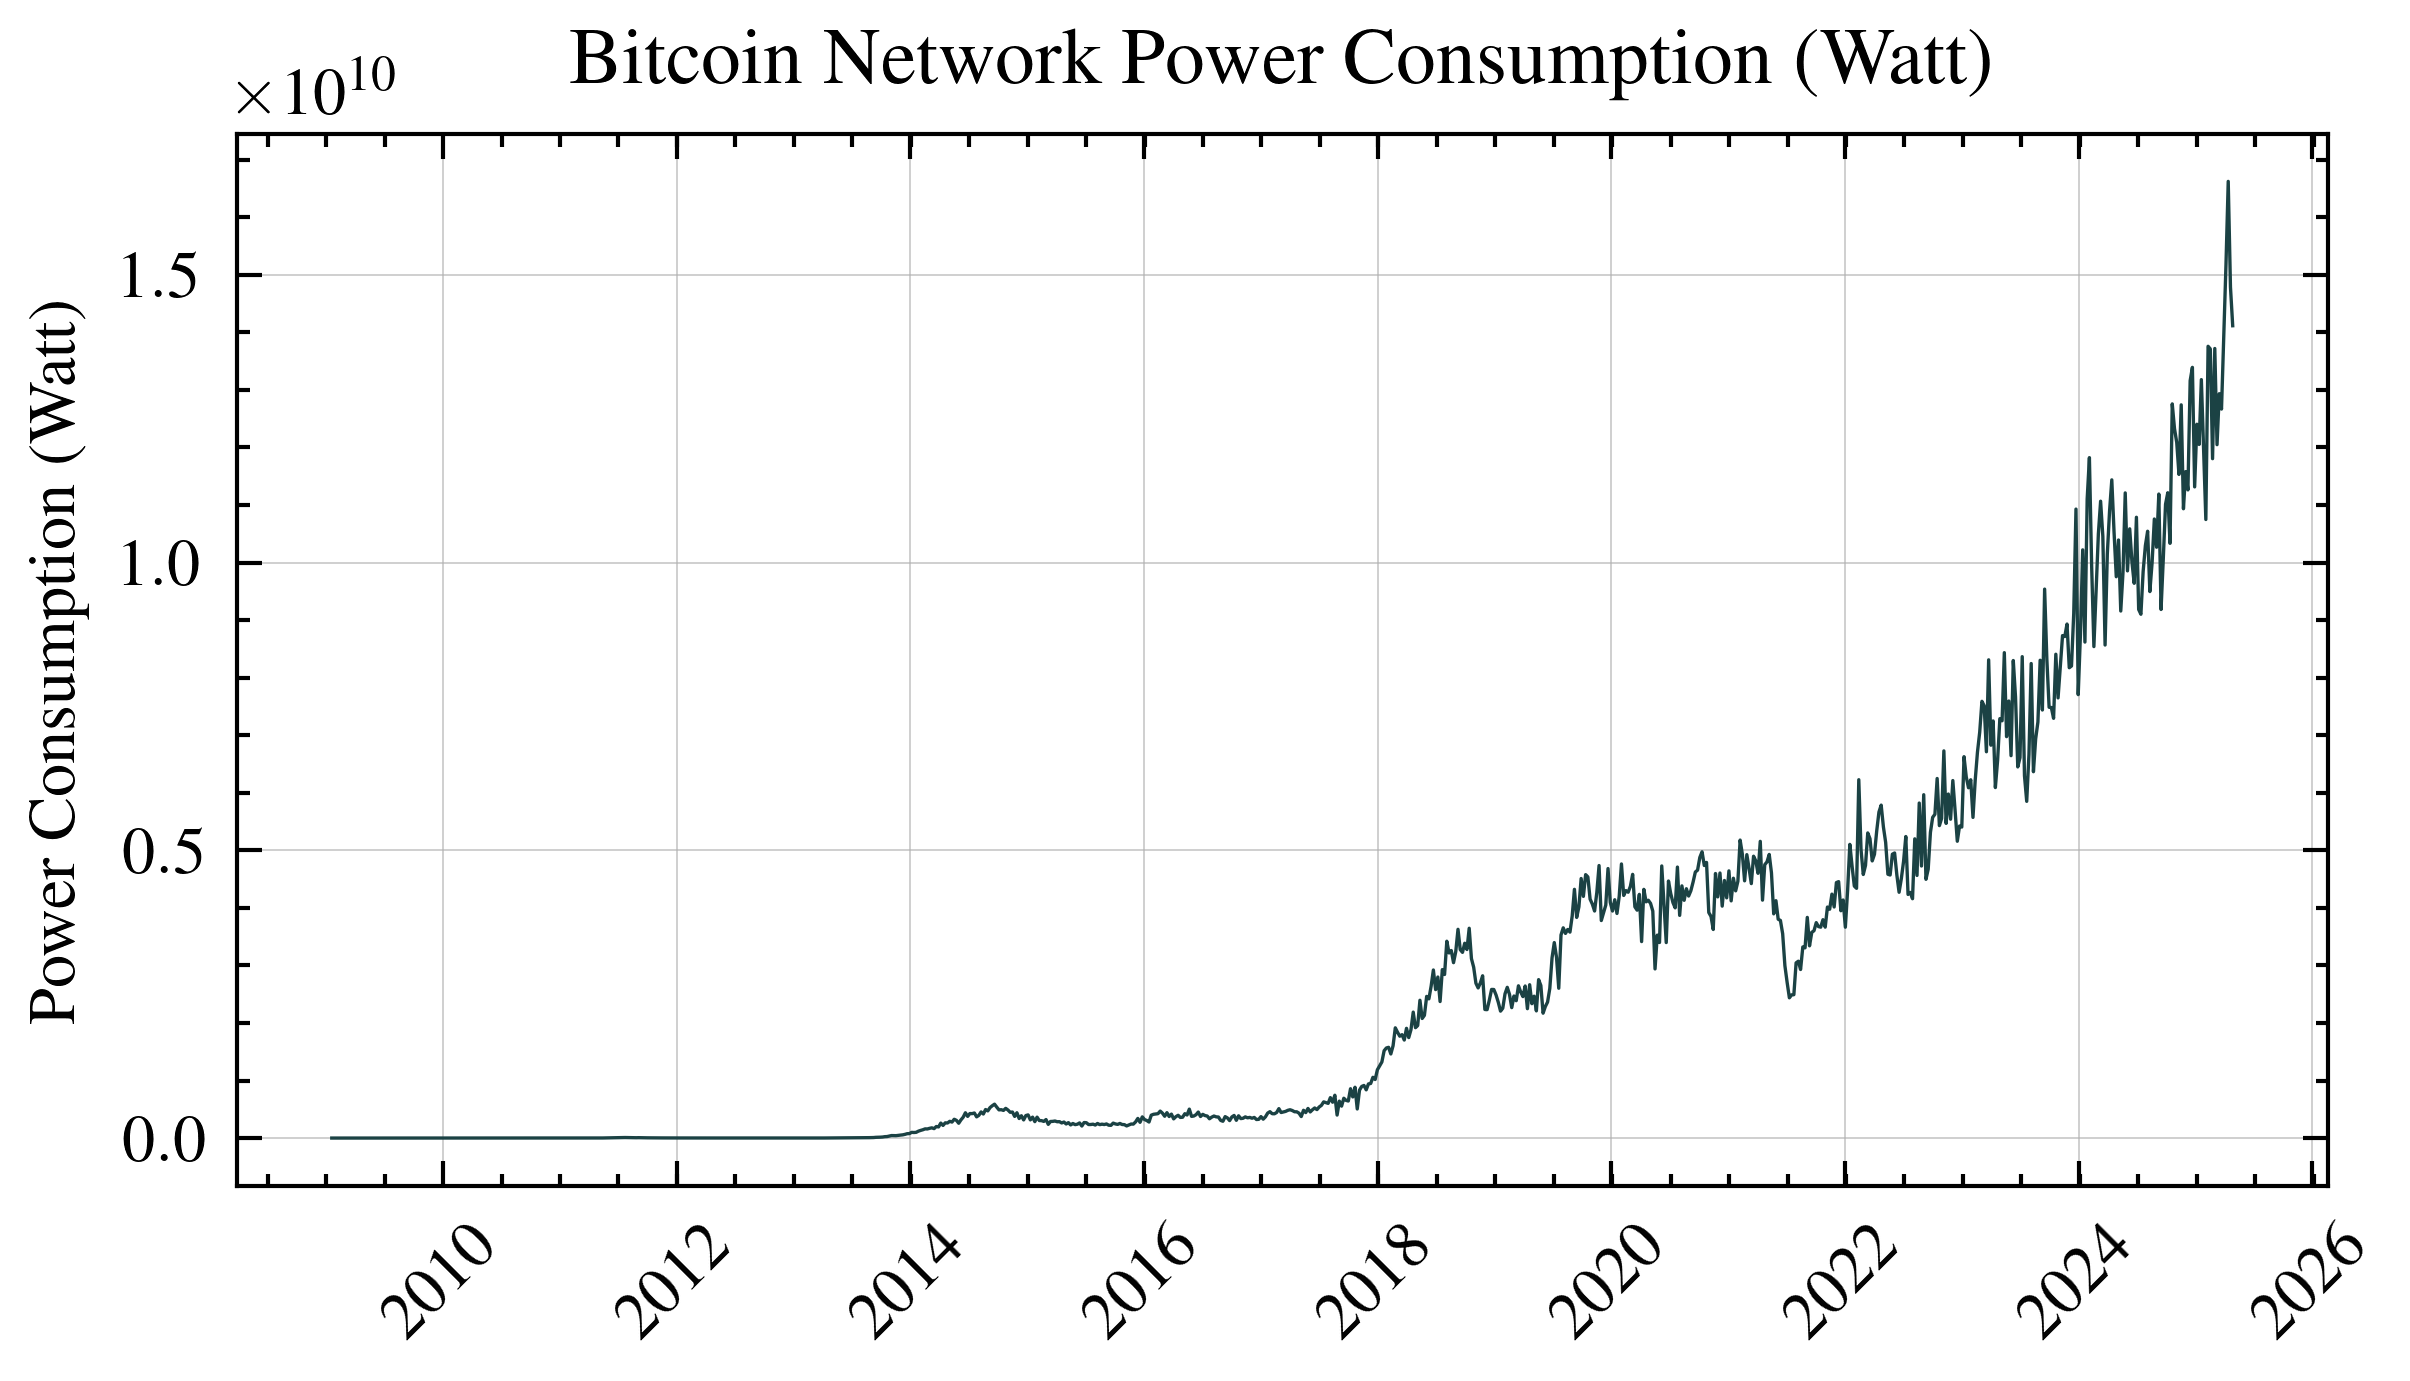

In [40]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df.index, df["Power Consumption (Watt)"], linestyle='-', linewidth=0.4, color=LINE_COLOR)
    plt.ylabel('Power Consumption (Watt)')
    plt.title('Bitcoin Network Power Consumption (Watt)')
    plt.savefig(ASSETS+'powerconsumption1.png')
    plt.show()

In [41]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def logistic(t, L, k, x0, offset):
    """
    A logistic (sigmoid) function:
        y(t) = offset + L / (1 + e^(-k*(t - x0)))
    where:
        L      = curve's maximum height above 'offset'
        k      = steepness of the curve
        x0     = the time value of the sigmoid's midpoint
        offset = vertical shift (minimum value)
    """
    return offset + L / (1.0 + np.exp(-k * (t - x0)))

def approximate_sigmoid(ts: pd.Series, L, forecast_days: int = 30) -> pd.Series:
    """
    Fit a logistic curve to the known part of the time series,
    then forecast forward 'forecast_days' days using the fitted curve.
    
    Parameters
    ----------
    ts : pd.Series
        A Pandas Series with a DatetimeIndex.
    forecast_days : int
        Number of days to forecast into the future.

    Returns
    -------
    pd.Series
        A Series containing the fitted values for the historical period
        plus the forecasted values for the future period.
    """
    # Ensure the Series is sorted by date
    ts = ts.sort_index()
    
    # Convert DatetimeIndex to a numeric scale: days from the start
    start_date = ts.index[0]
    x_known = (ts.index - start_date).days.values.astype(float)
    
    # Known values
    y_known = ts.values.astype(float)
    
    # Initial guesses for L, k, x0, offset (try to set them sensibly)
    k_init = 0.1                              # guess for steepness
    x0_init = x_known.mean()                  # midpoint near center of the known data
    offset_init = y_known.min()               # minimal value as offset
    
    initial_guesses = [k_init, x0_init, offset_init]

    func = lambda x, k, x0, offset: logistic(x, L, k, x0, offset)

    # Fit the logistic function to the known data
    popt, pcov = curve_fit(func, x_known, y_known, p0=initial_guesses,maxfev=10_000)
    
    # Extract fitted parameters
    k_fit, x0_fit, offset_fit = popt
    print(k_fit, x0_fit, offset_fit)
    
    # Create a combined time range: known + forecast
    last_date = ts.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=forecast_days,
                                 freq='D')
    
    all_dates = ts.index.union(future_dates)
    
    # Convert all times to numeric for forecasting
    x_all = (all_dates - start_date).days.values.astype(float)
    
    # Apply the fitted logistic function to the entire date range
    y_all = func(x_all,  k_fit, x0_fit, offset_fit)
    
    # Return as a Pandas Series
    fitted_forecast = pd.Series(data=y_all, index=all_dates)
    return fitted_forecast

In [42]:
MAX_ENERGY = df["Power Consumption (Watt)"][-1]*1.5
forecast_series = approximate_sigmoid(df["Power Consumption (Watt)"], MAX_ENERGY, forecast_days=365*120)
last = df["Power Consumption (Watt)"][df.index[-1]]
last_date = df.index[-1]

0.0011013752801704232 5715.814962421925 -39672230.77232359


C:\Users\pkapl\AppData\Local\Temp\ipykernel_12528\4036602926.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MAX_ENERGY = df["Power Consumption (Watt)"][-1]*1.5


In [43]:
delta = forecast_series.iloc[(forecast_series-last).abs().argsort()[:1]].index-last_date
forecast_series=forecast_series.shift(-delta.days[0])[last_date:]

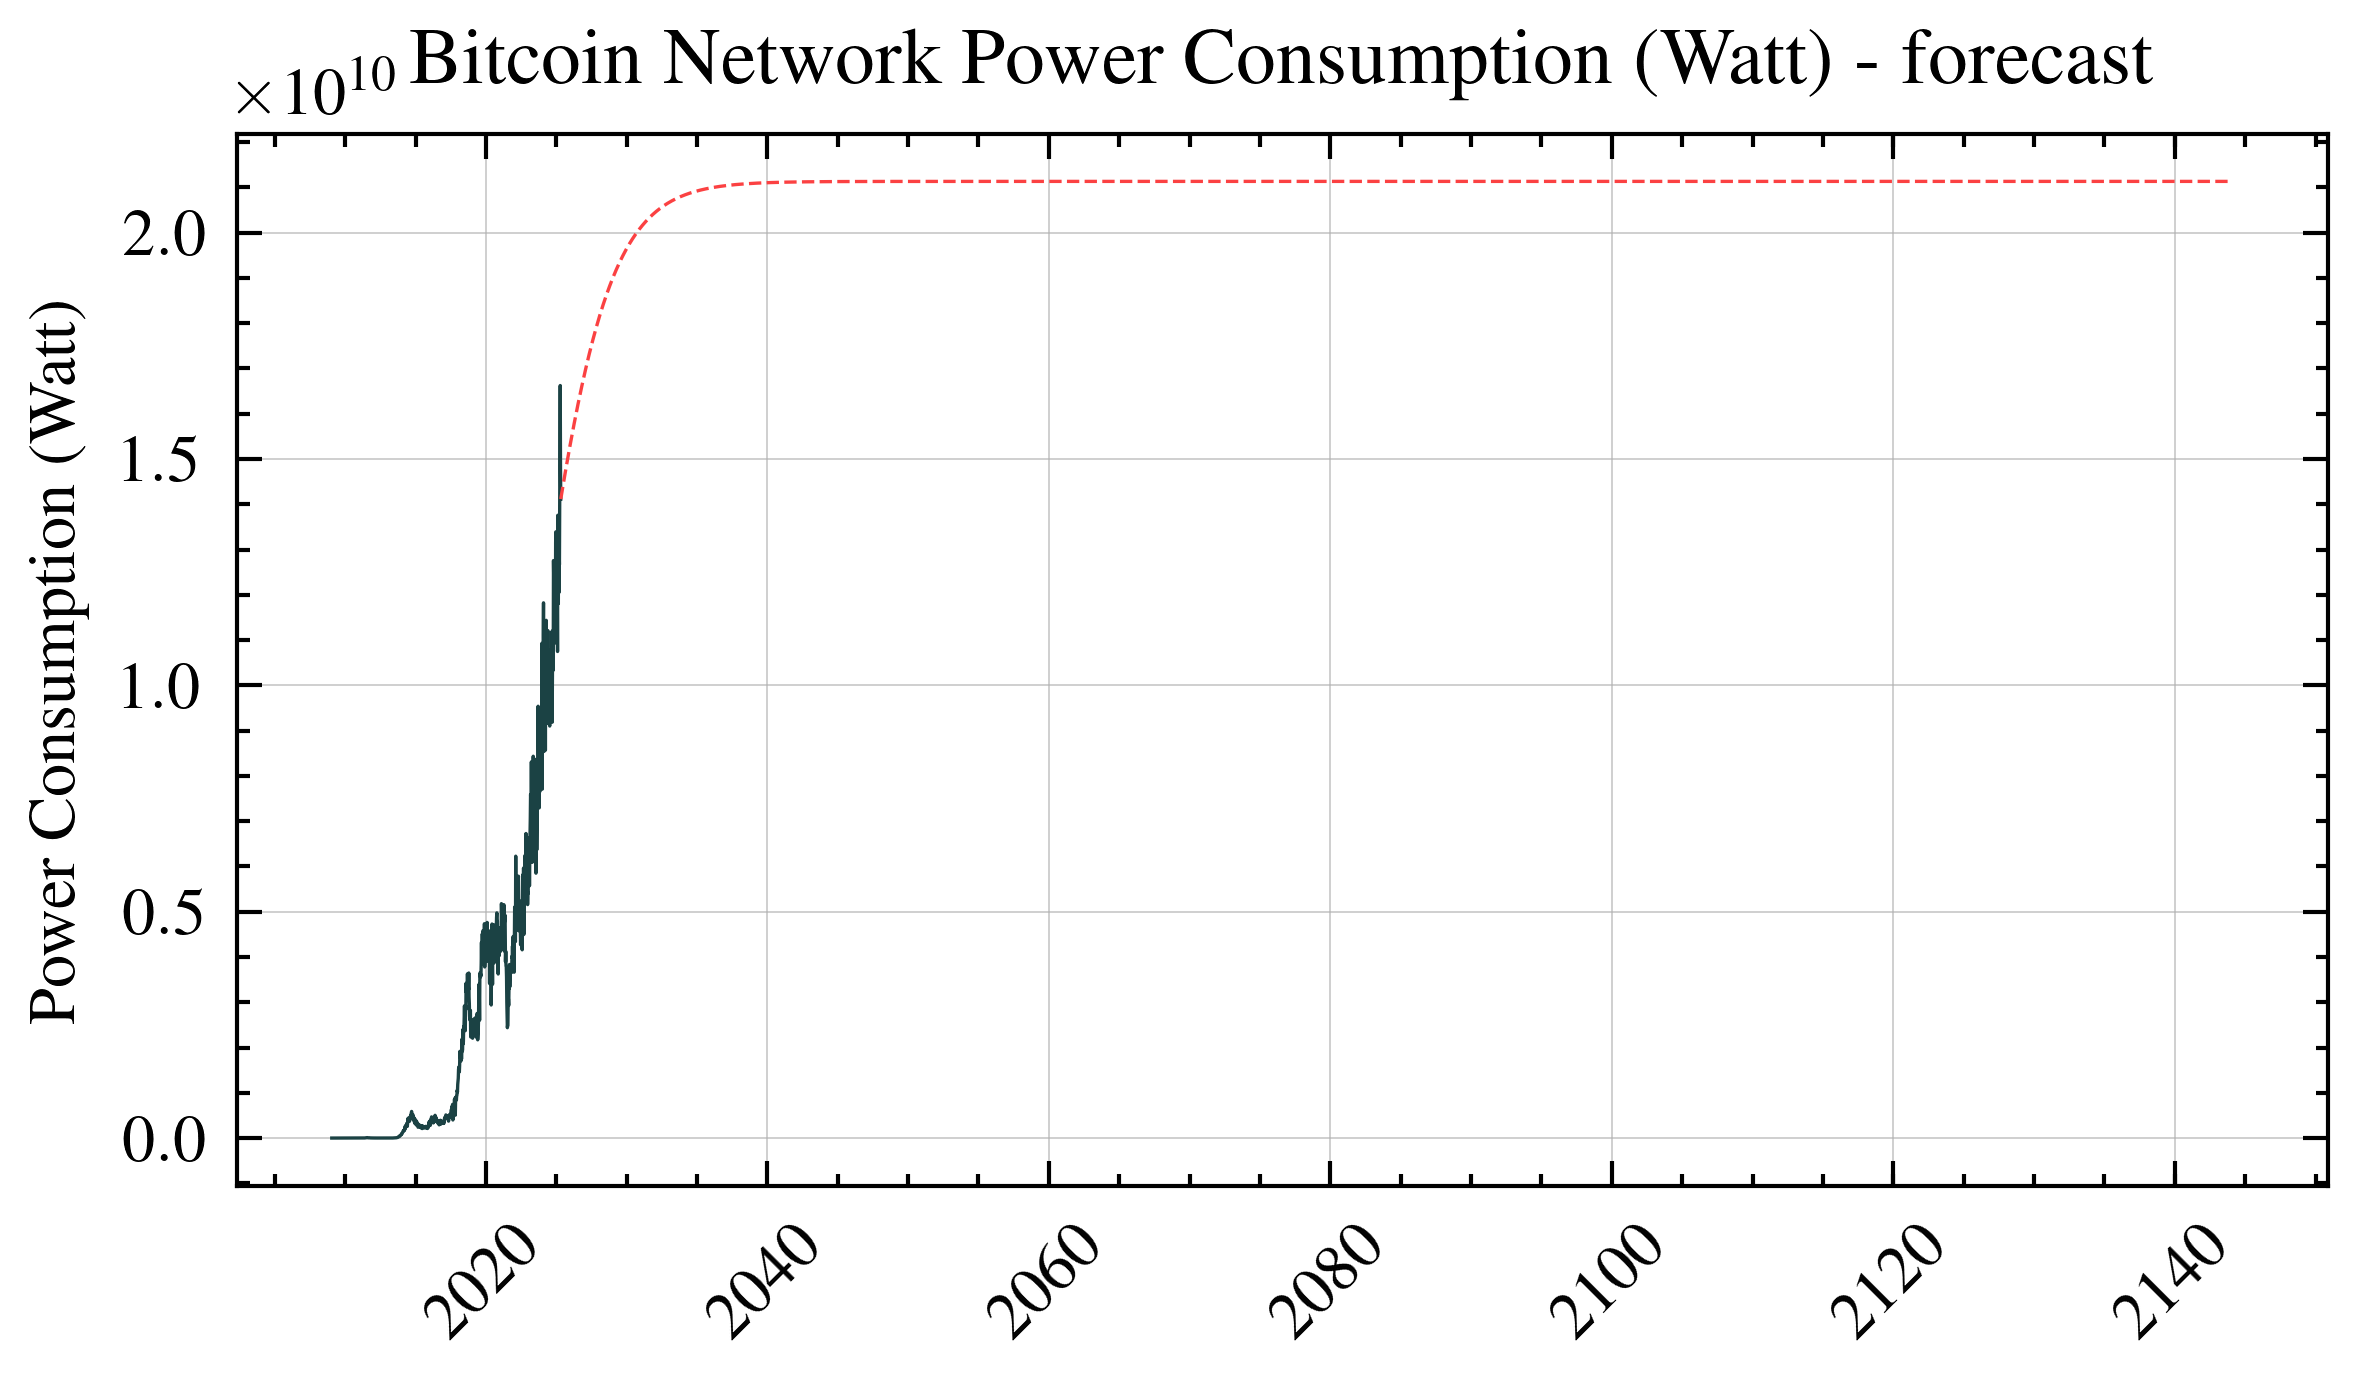

In [44]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df.index, df["Power Consumption (Watt)"], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(forecast_series.index, forecast_series, linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Power Consumption (Watt)')
    plt.title('Bitcoin Network Power Consumption (Watt) - forecast')
    plt.savefig(ASSETS+'powerconsumptionforecast1.png')
    plt.show()

In [45]:
forecast_df = pd.DataFrame(forecast_series,columns=["Power Consumption (Watt)"]).resample("W-SUN").last().dropna()
forecast_df=pd.concat([df["Power Consumption (Watt)"],forecast_df[1:]])

In [46]:
np.random.seed(12345)

In [47]:
last_known_value = df['daily_transaction_fees'].dropna().iloc[-1]
last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date,
                                periods=120*(365/7),
                                freq='W-SUN')
# Convert all times to numeric for forecasting
x_all = (future_dates - start_date).days.values.astype(float)
# Apply the fitted logistic function to the entire date range
y_all = logistic(x_all,last_known_value*20,0.0005,3000.,last_known_value)*np.random.uniform(0.1,1.0,len(x_all))
tran_fees = pd.concat([df[['daily_transaction_fees']],pd.DataFrame(pd.Series(data=y_all, index=future_dates), columns=['daily_transaction_fees'])])
tran_fees=tran_fees.resample('D').interpolate('linear').resample('W-SUN').last()

C:\Users\pkapl\AppData\Local\Temp\ipykernel_12528\1338032051.py:4: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  future_dates = pd.date_range(start=start_date,


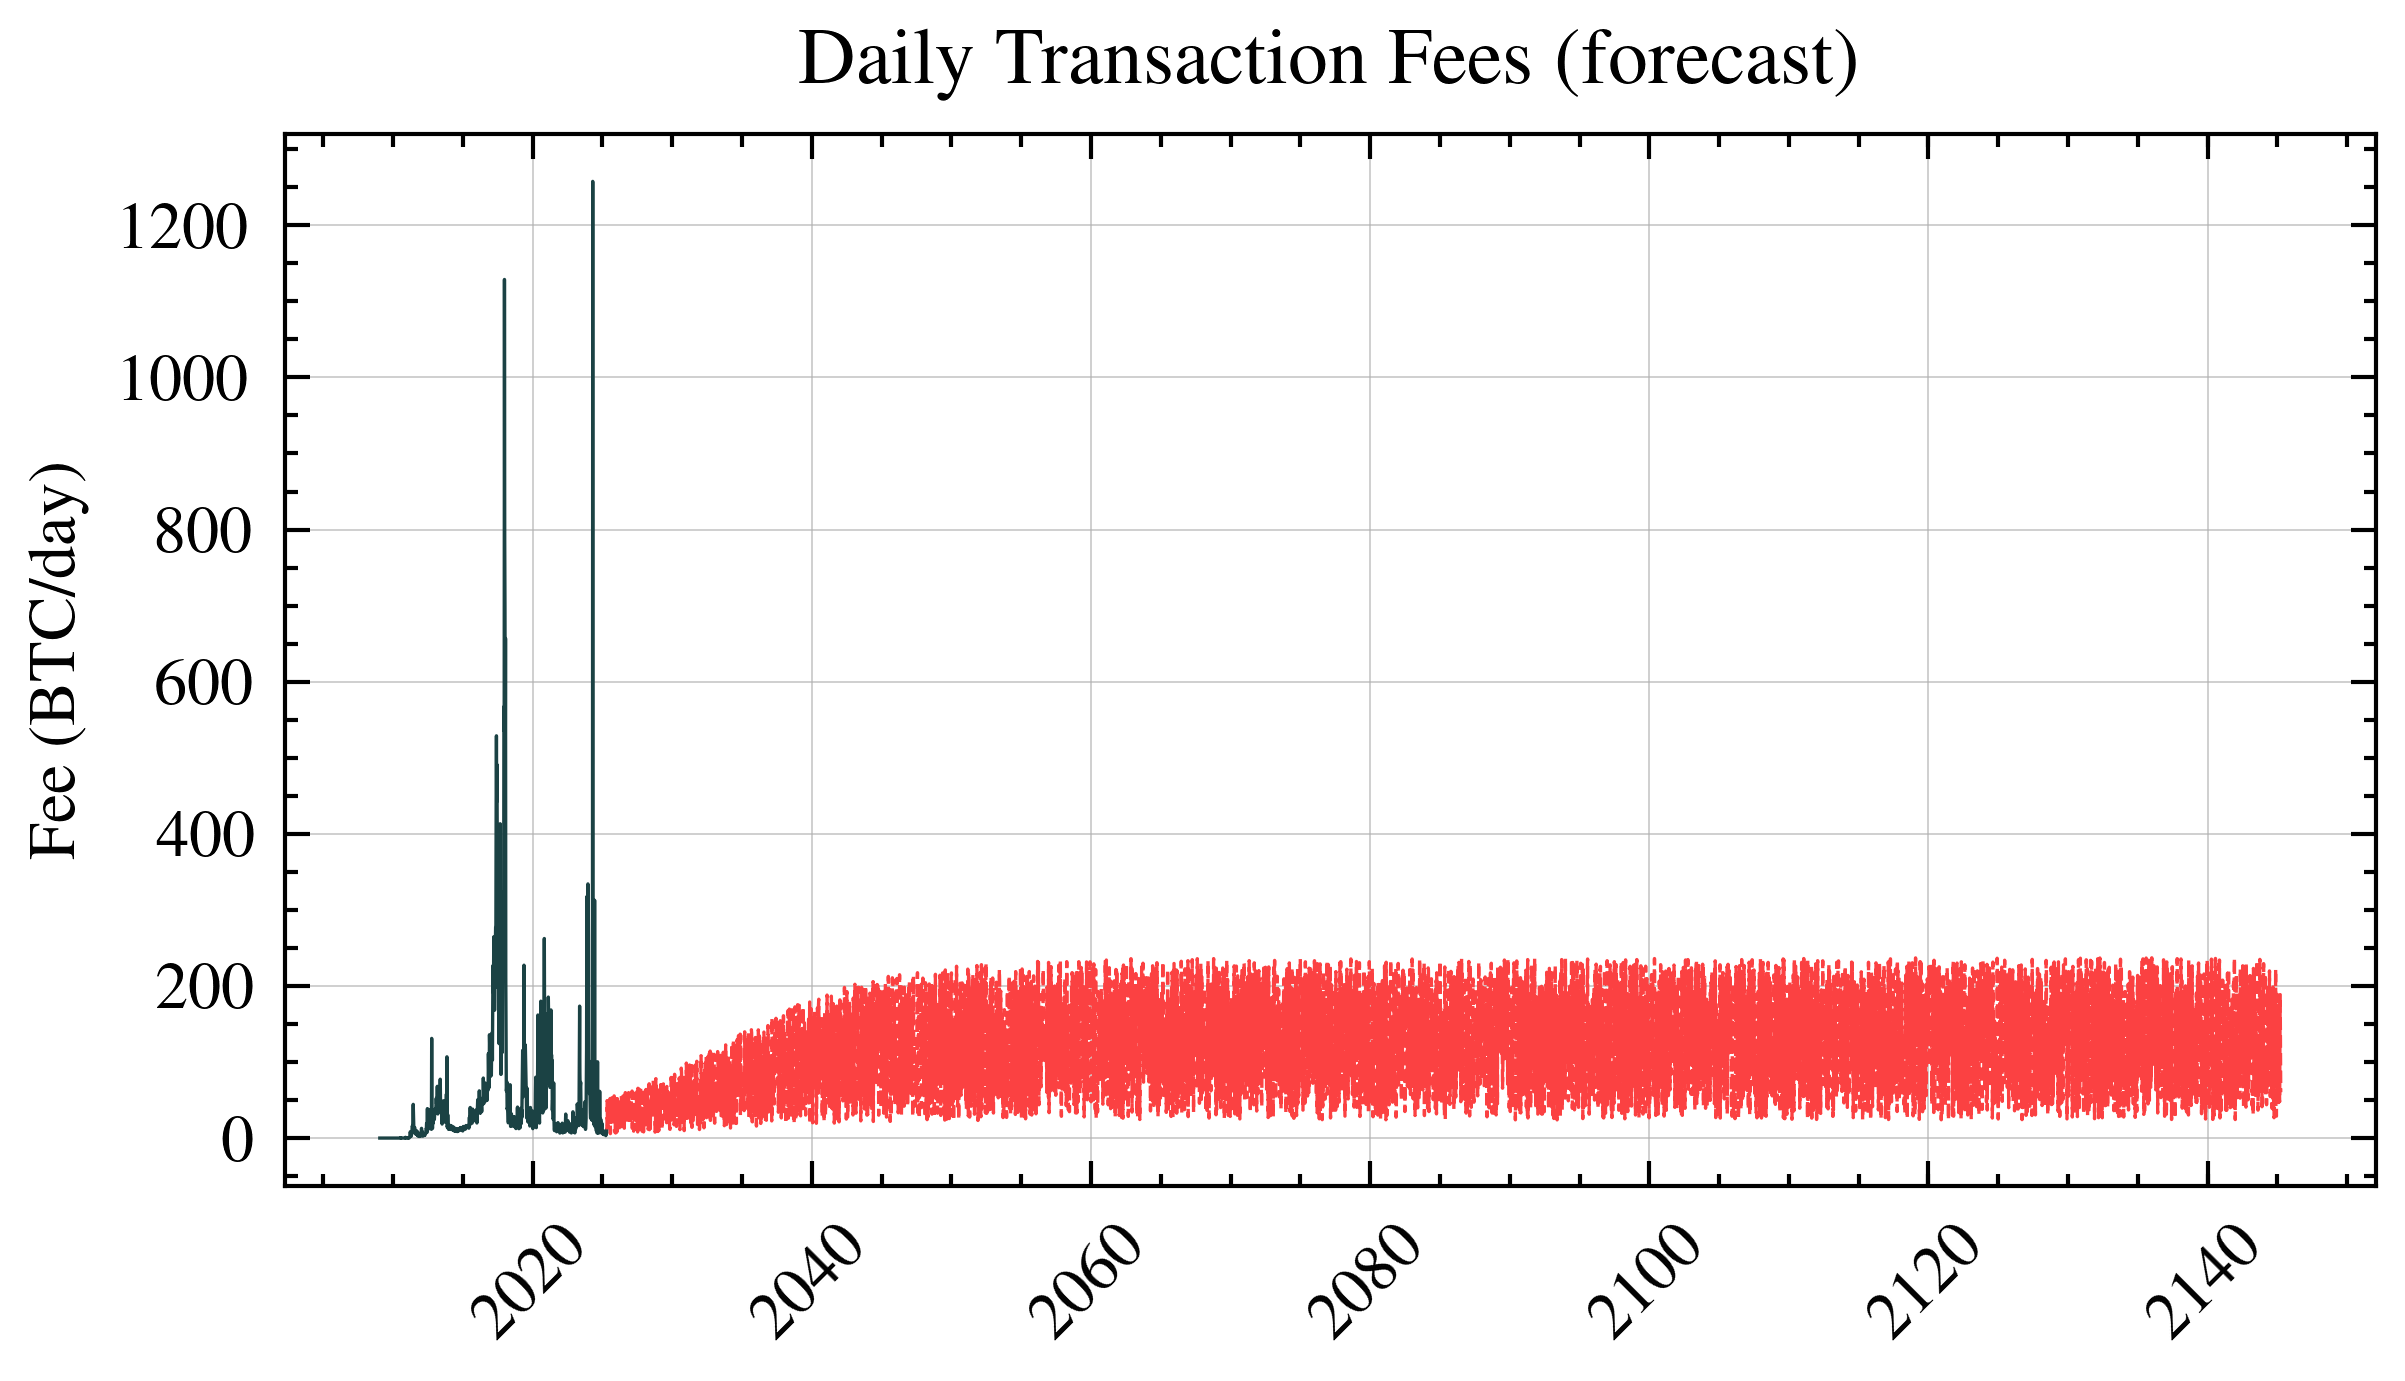

In [48]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(tran_fees[:df.index[-1]].index, tran_fees[:df.index[-1]]['daily_transaction_fees'], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(tran_fees[df.index[-1]:].index, tran_fees[df.index[-1]:]['daily_transaction_fees'], linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Fee (BTC/day)')
    plt.title('Daily Transaction Fees (forecast)')
    plt.savefig(ASSETS+'transactionfeesforecast1.png')
    plt.show()
    

In [50]:
main_df=forecast_df.join(tran_fees,how="outer").join(electricity_price).join(total_bitcoins).join(simulated_bitcoins.rename(columns={"total_bitcoins":"simulated_total_bitcoins"}),how="outer")
main_df['delta_total_bitcoins'] = main_df['total_bitcoins'].diff().rolling(4).mean()+(main_df['daily_transaction_fees']*7)
main_df['mining_cost'] = ((main_df["Power Consumption (Watt)"]  / 1000 * 24 * 7 * main_df['COM']/100) / main_df['delta_total_bitcoins']).rolling(window=4).mean()
main_df=main_df.join(onchain[['market_price']])

In [51]:
main_df["delta_simulated_total_bitcoins_annual"]=(main_df['simulated_total_bitcoins'].diff())*365/7
main_df["stock_to_flow"]=np.exp(-1.84)*(main_df["simulated_total_bitcoins"]/main_df["delta_simulated_total_bitcoins_annual"])**3.36
#main_df["stock_to_flow"]=0.25*(main_df["simulated_total_bitcoins"]/main_df["delta_simulated_total_bitcoins_annual"])**3

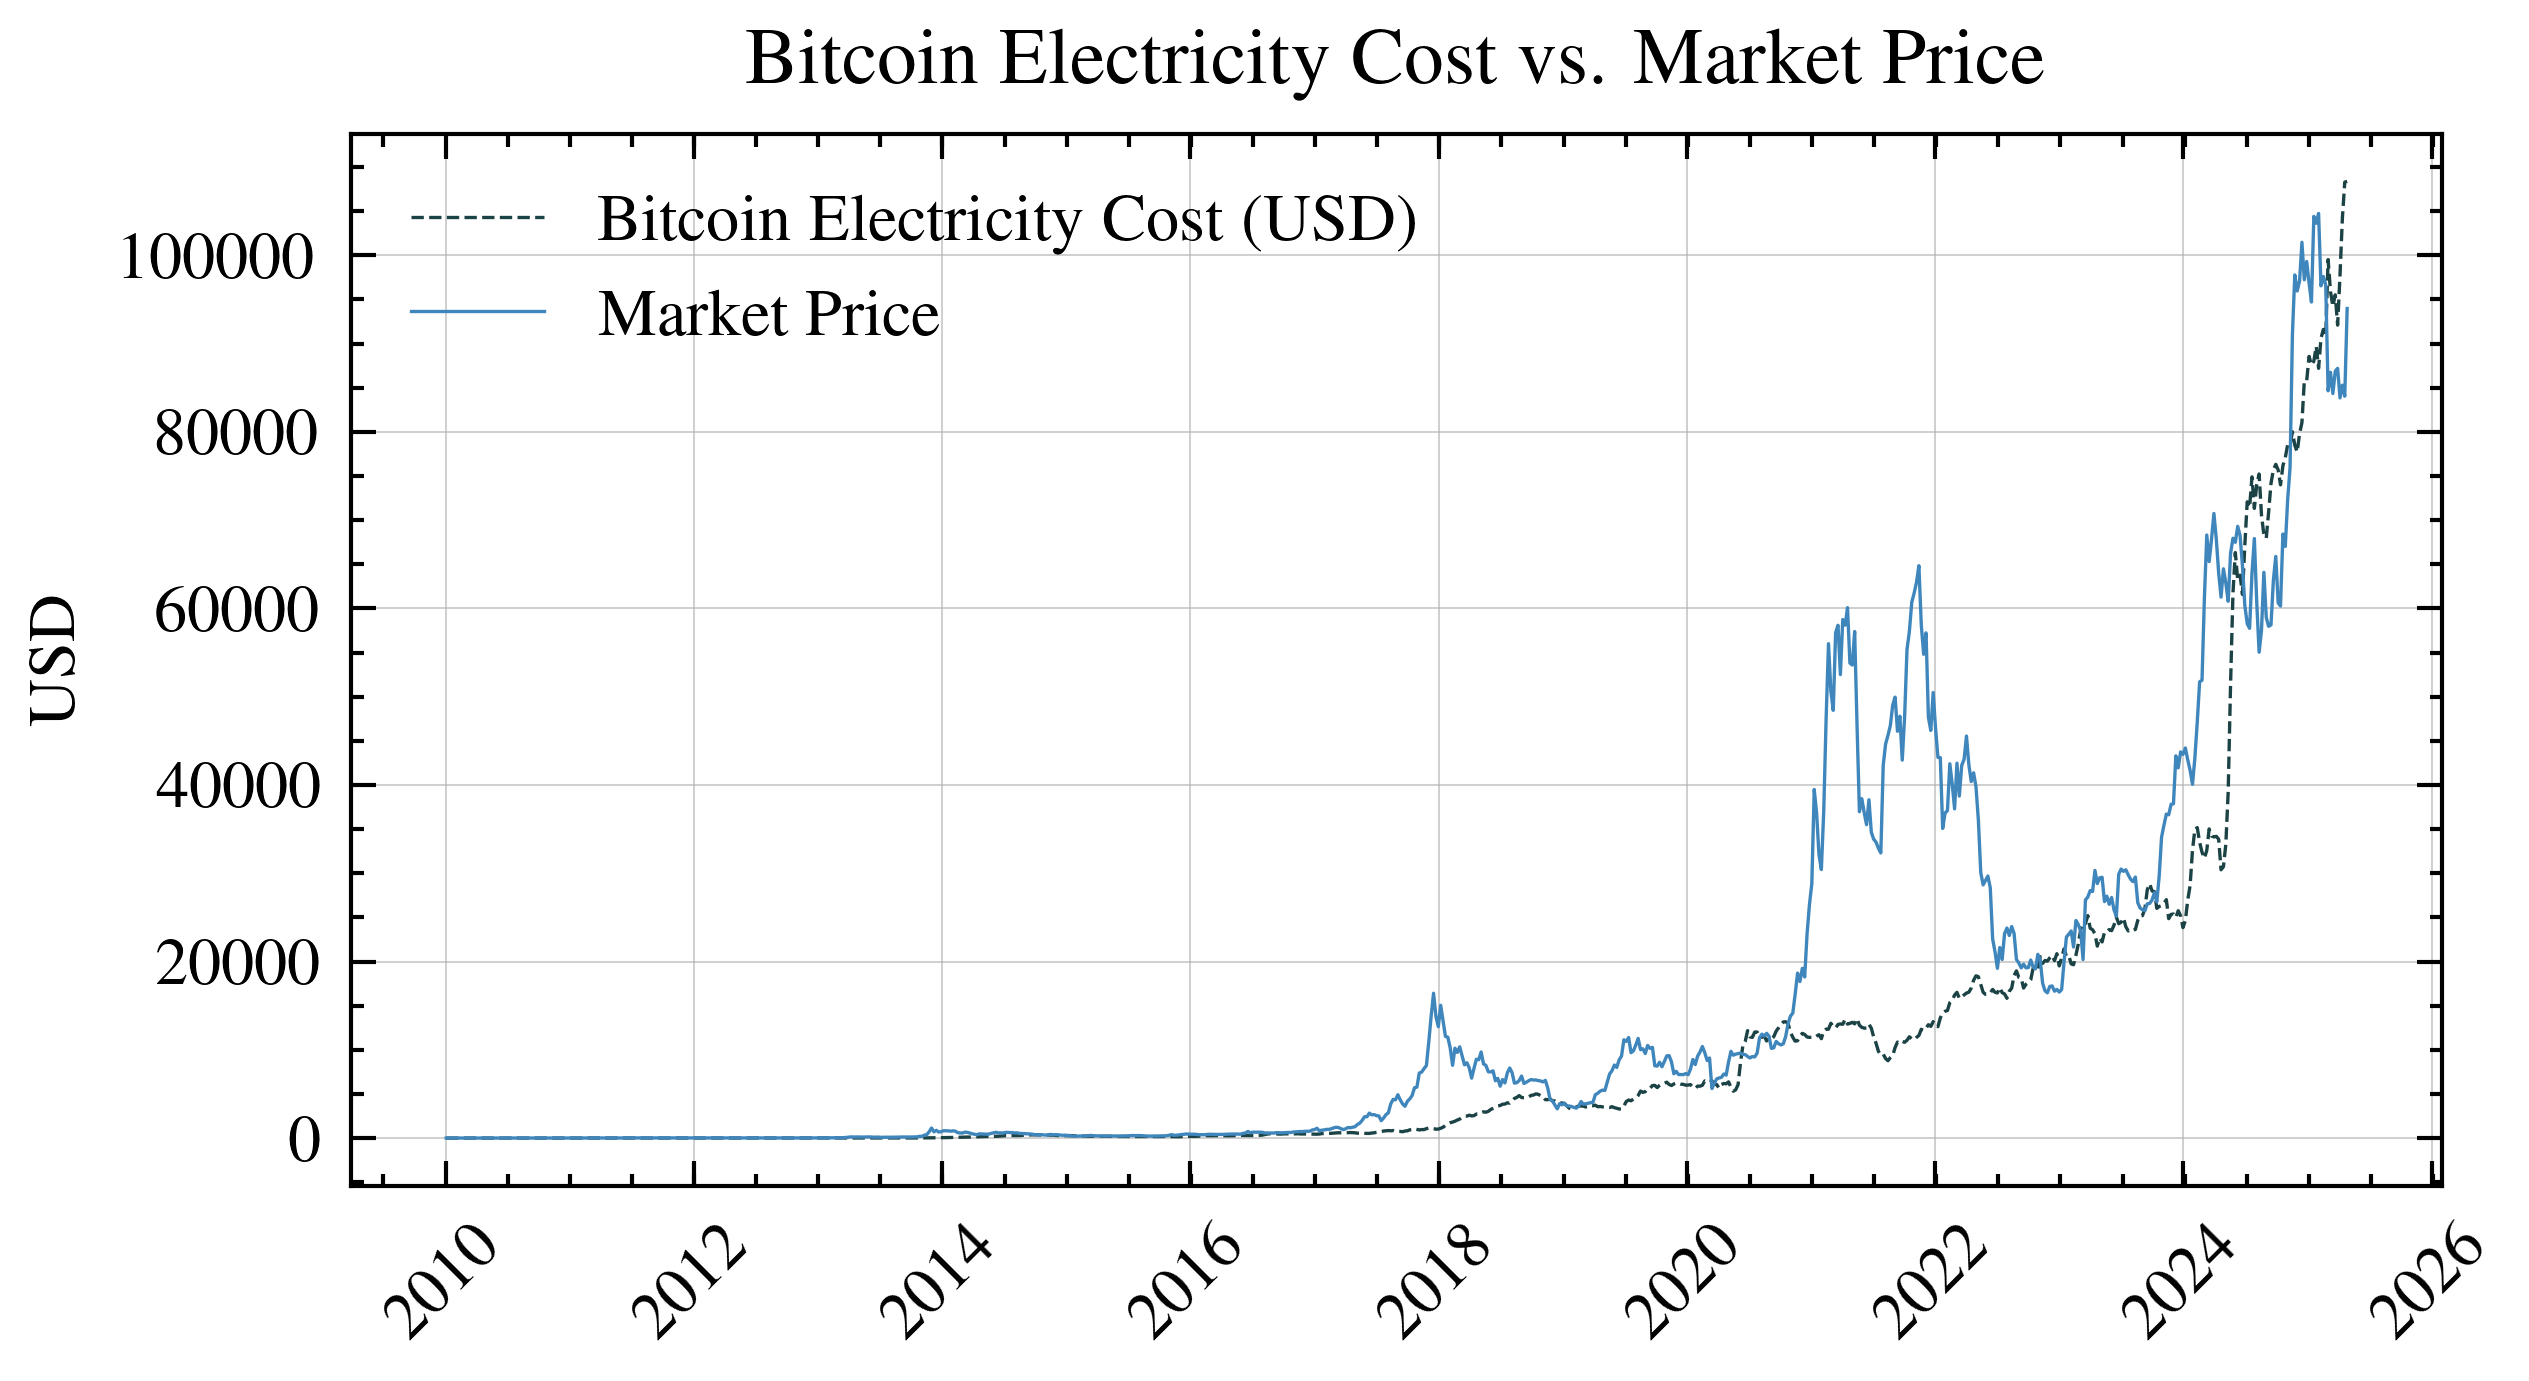

In [52]:
df_filtered = main_df['2010-01-01':df.index[-1]].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered.index, df_filtered['mining_cost'], label='Bitcoin Electricity Cost (USD)', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.savefig(ASSETS+'miningcost1.png')
    plt.show()

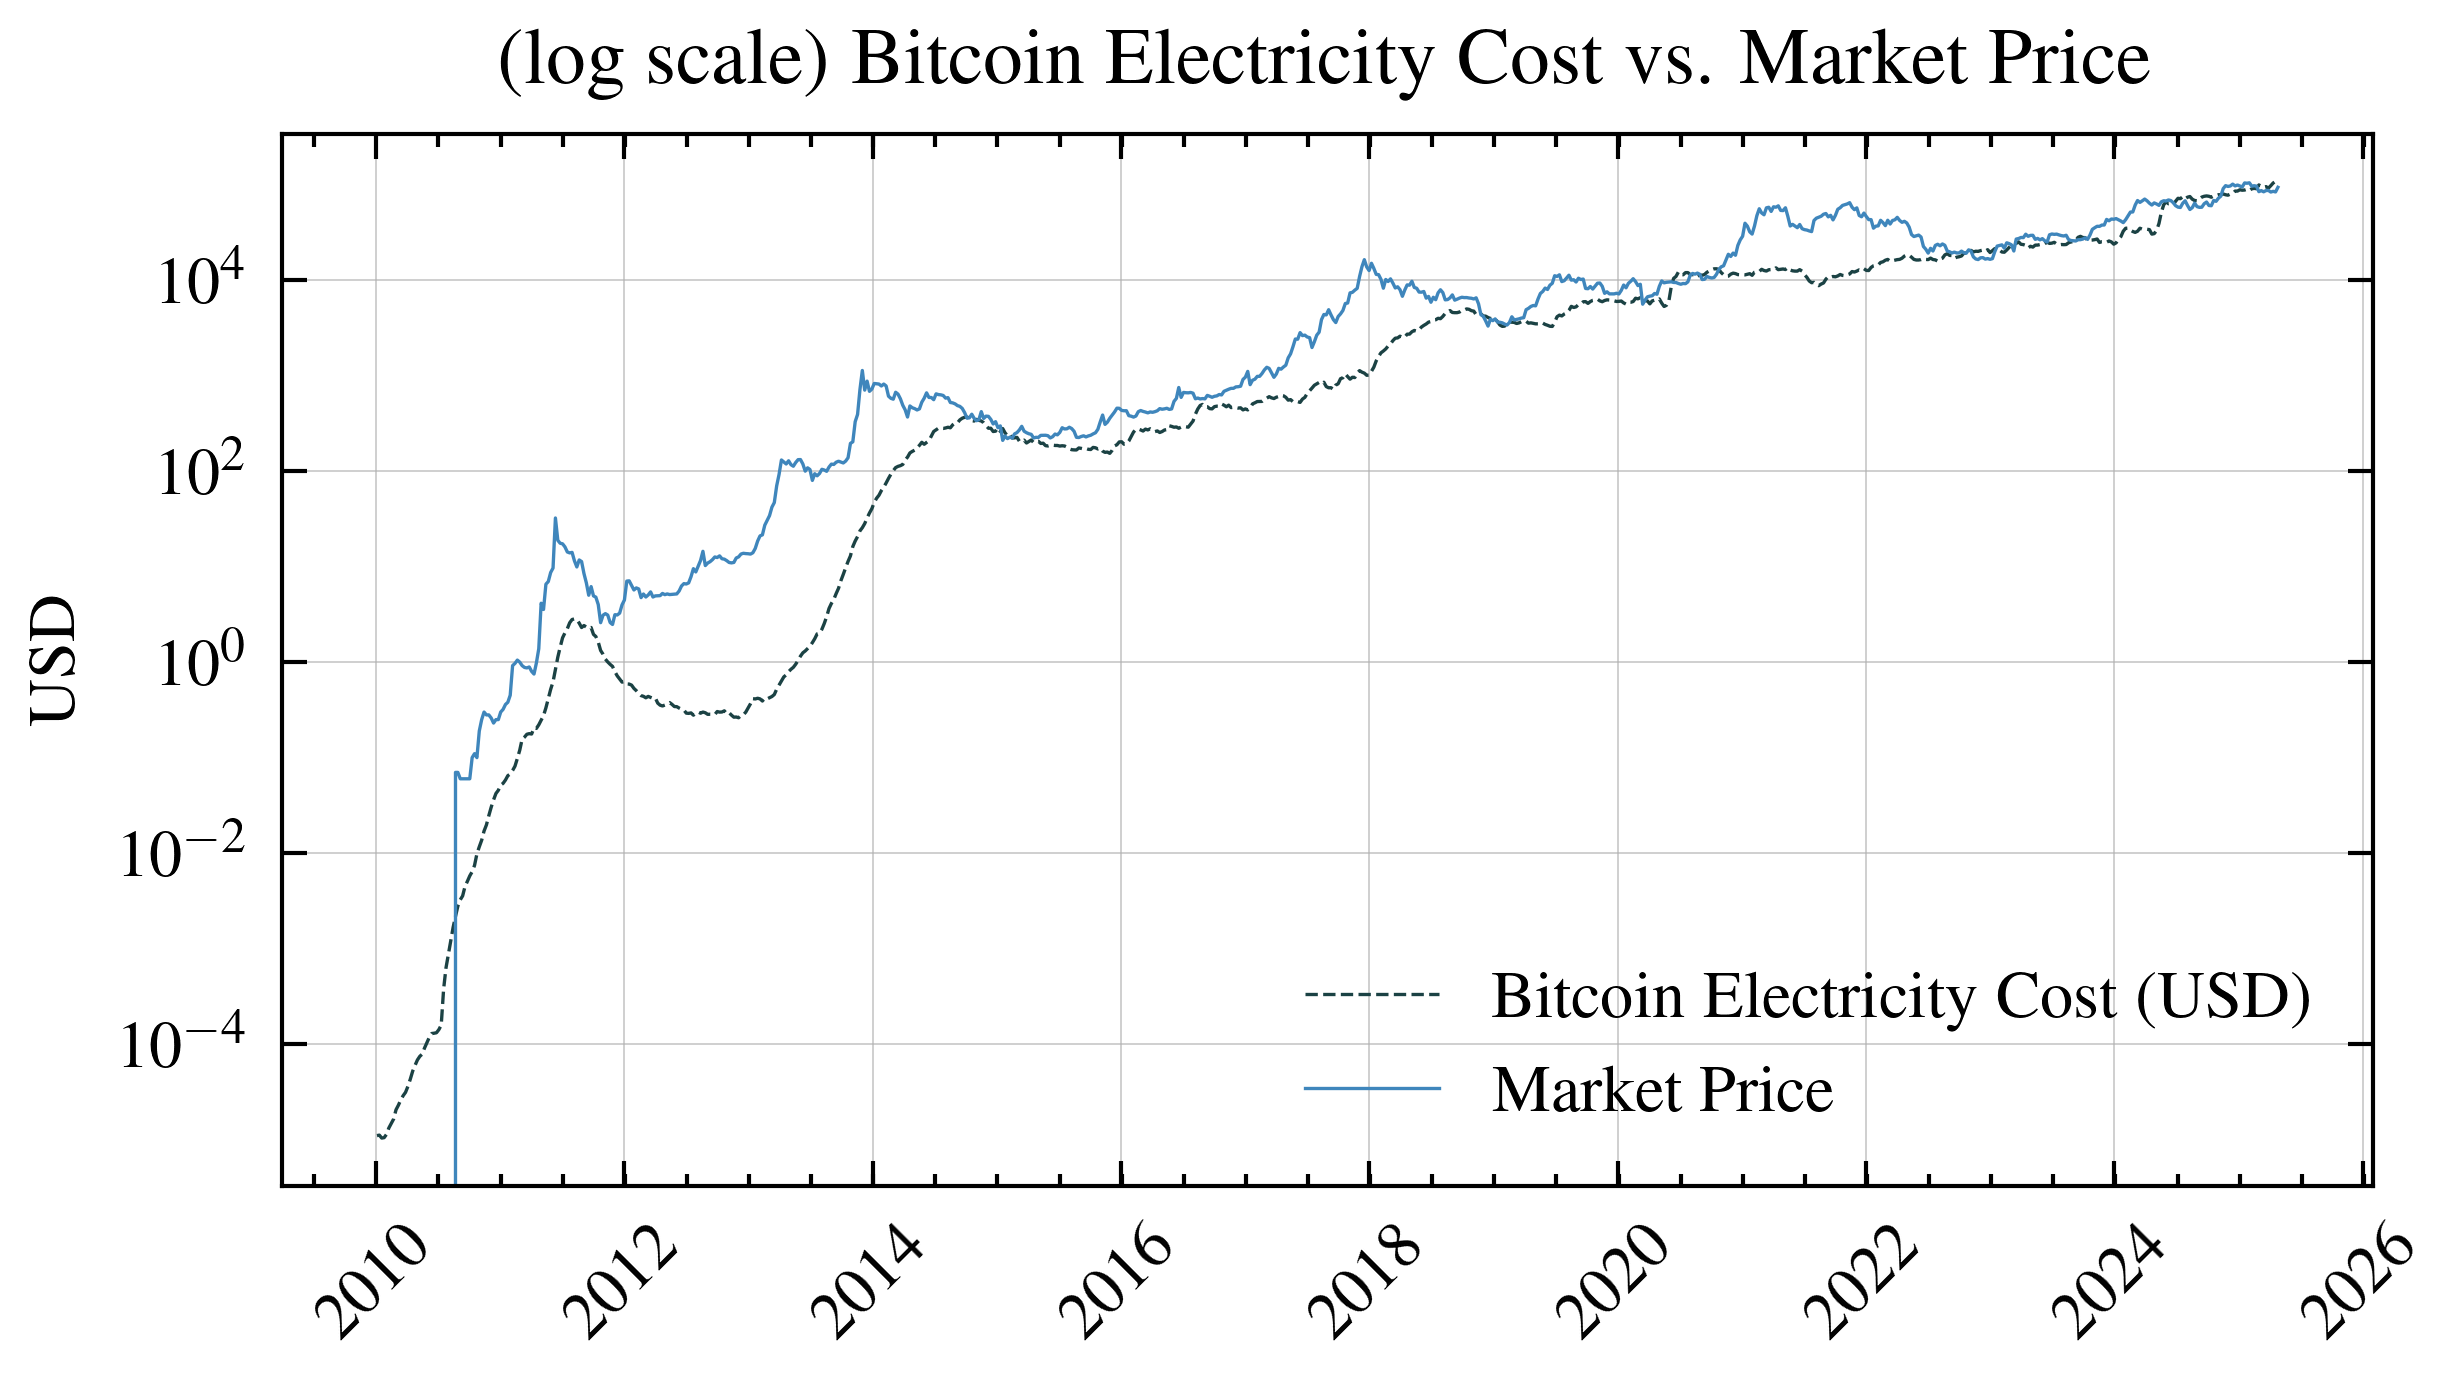

In [53]:
df_filtered = main_df['2010-01-01':df.index[-1]].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered.index, df_filtered['mining_cost'], label='Bitcoin Electricity Cost (USD)', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('(log scale) Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcost2.png')
    plt.show()

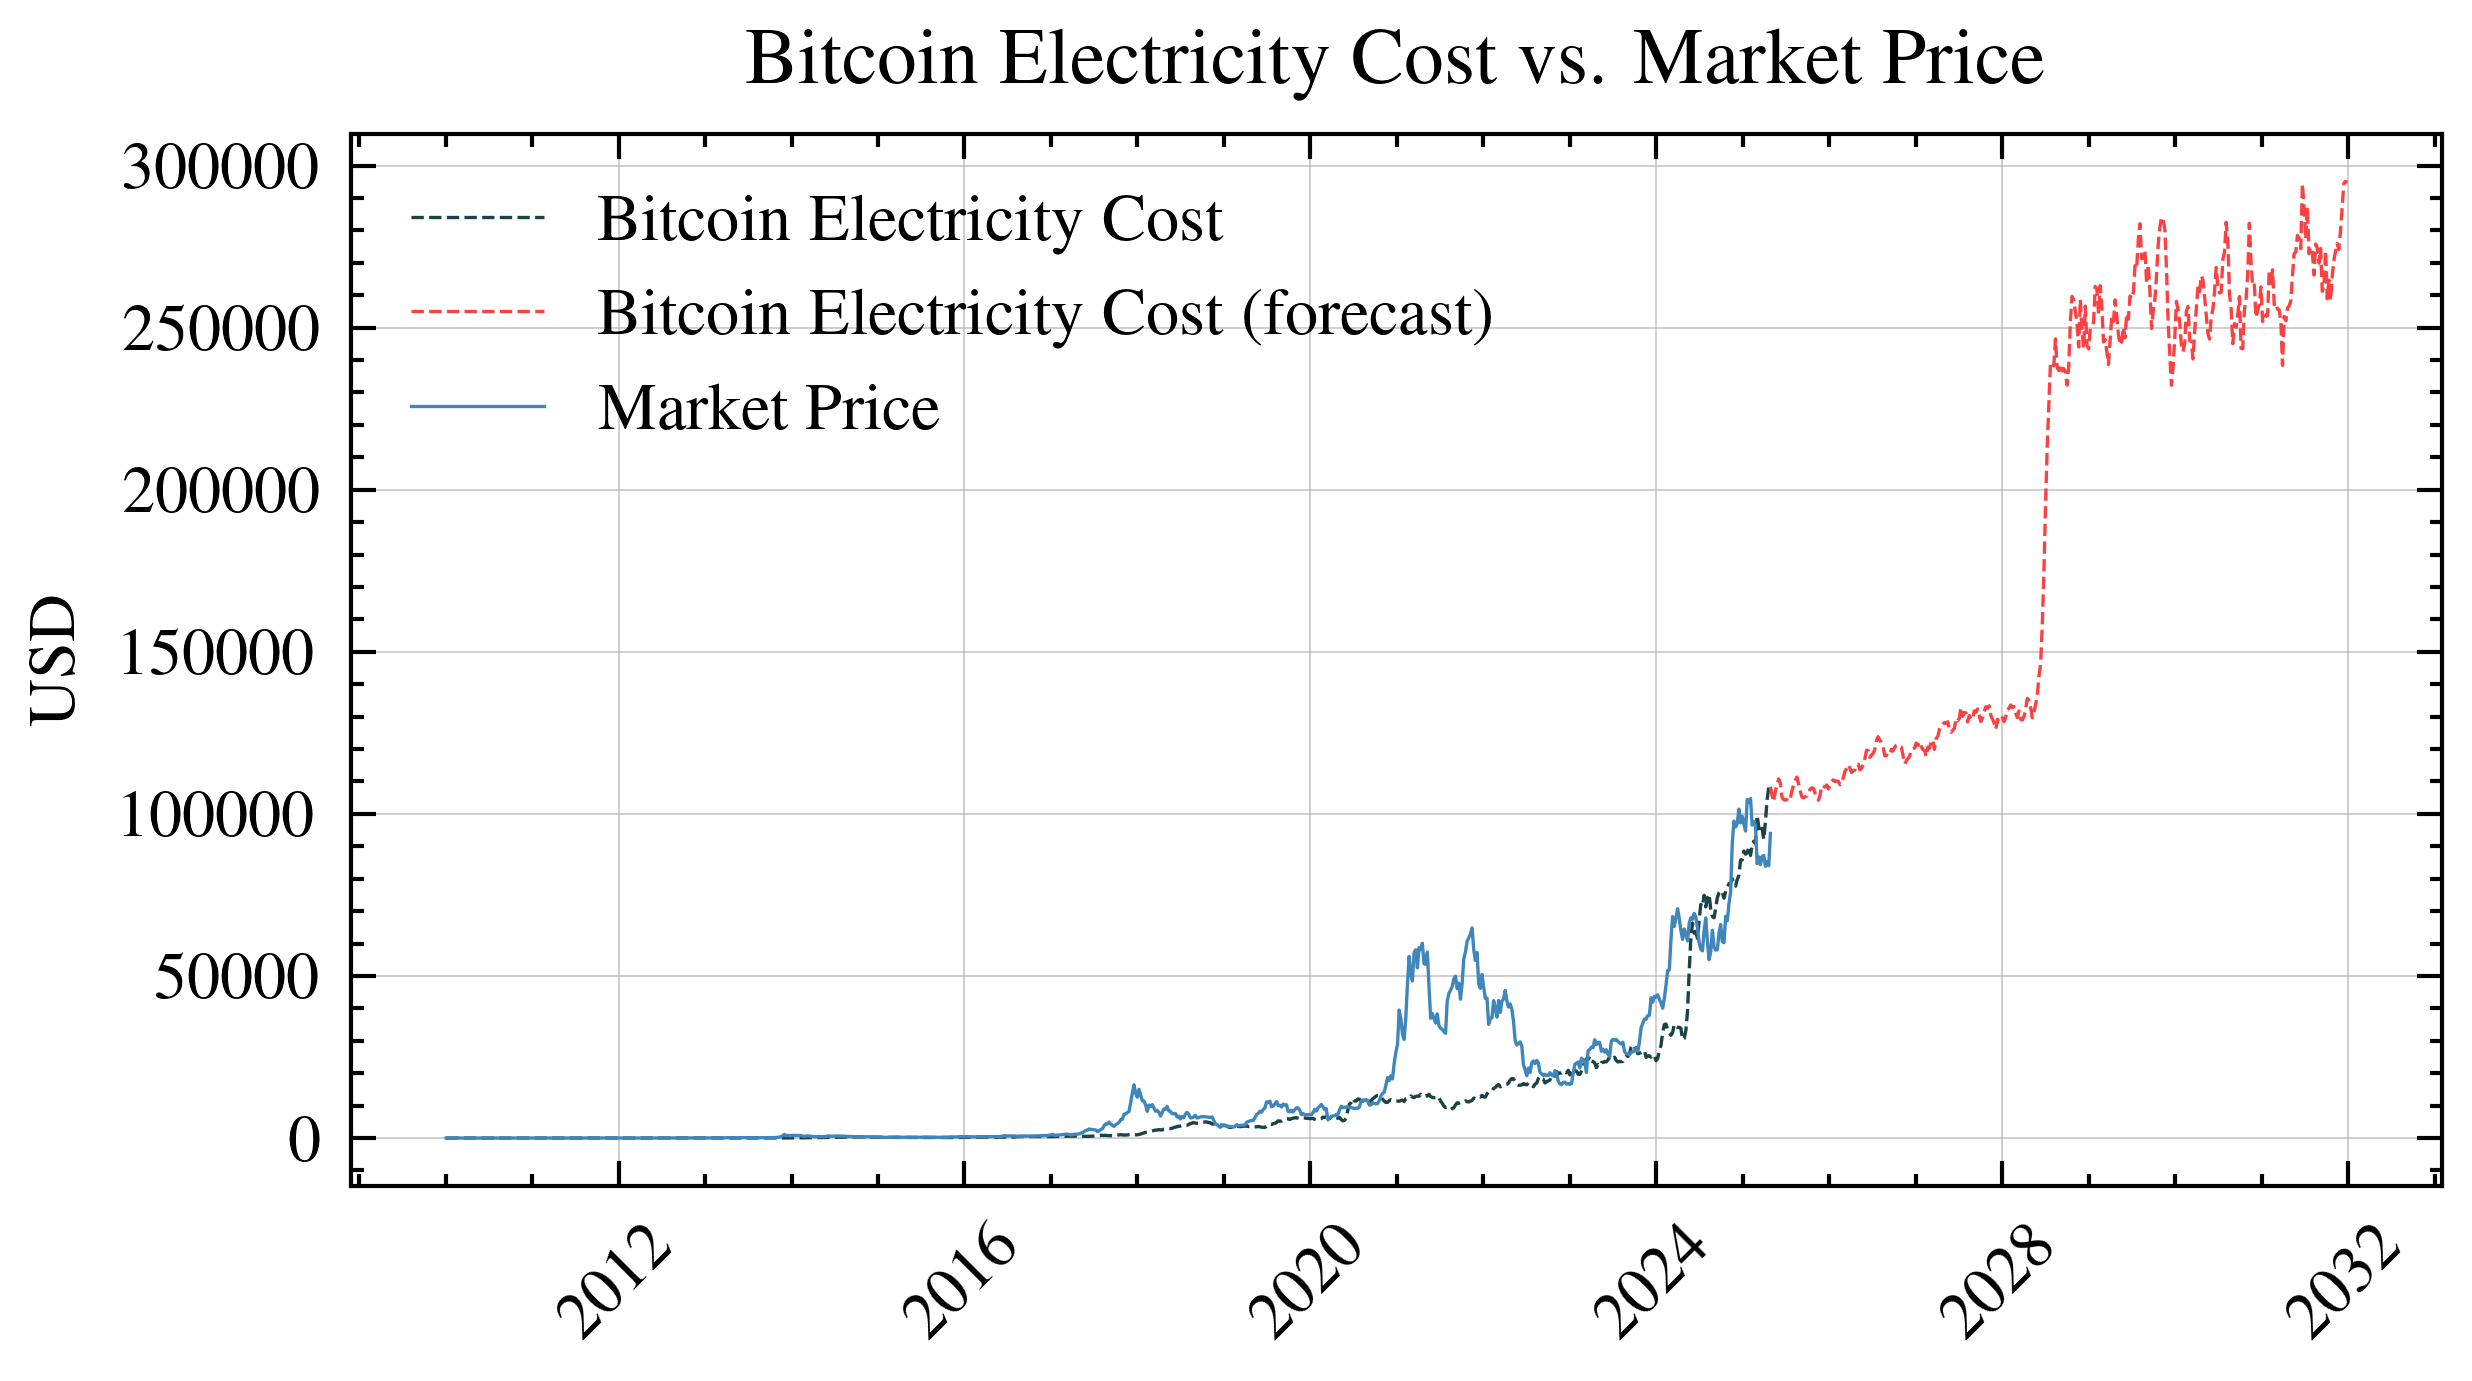

In [54]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast1.png')
    plt.show()

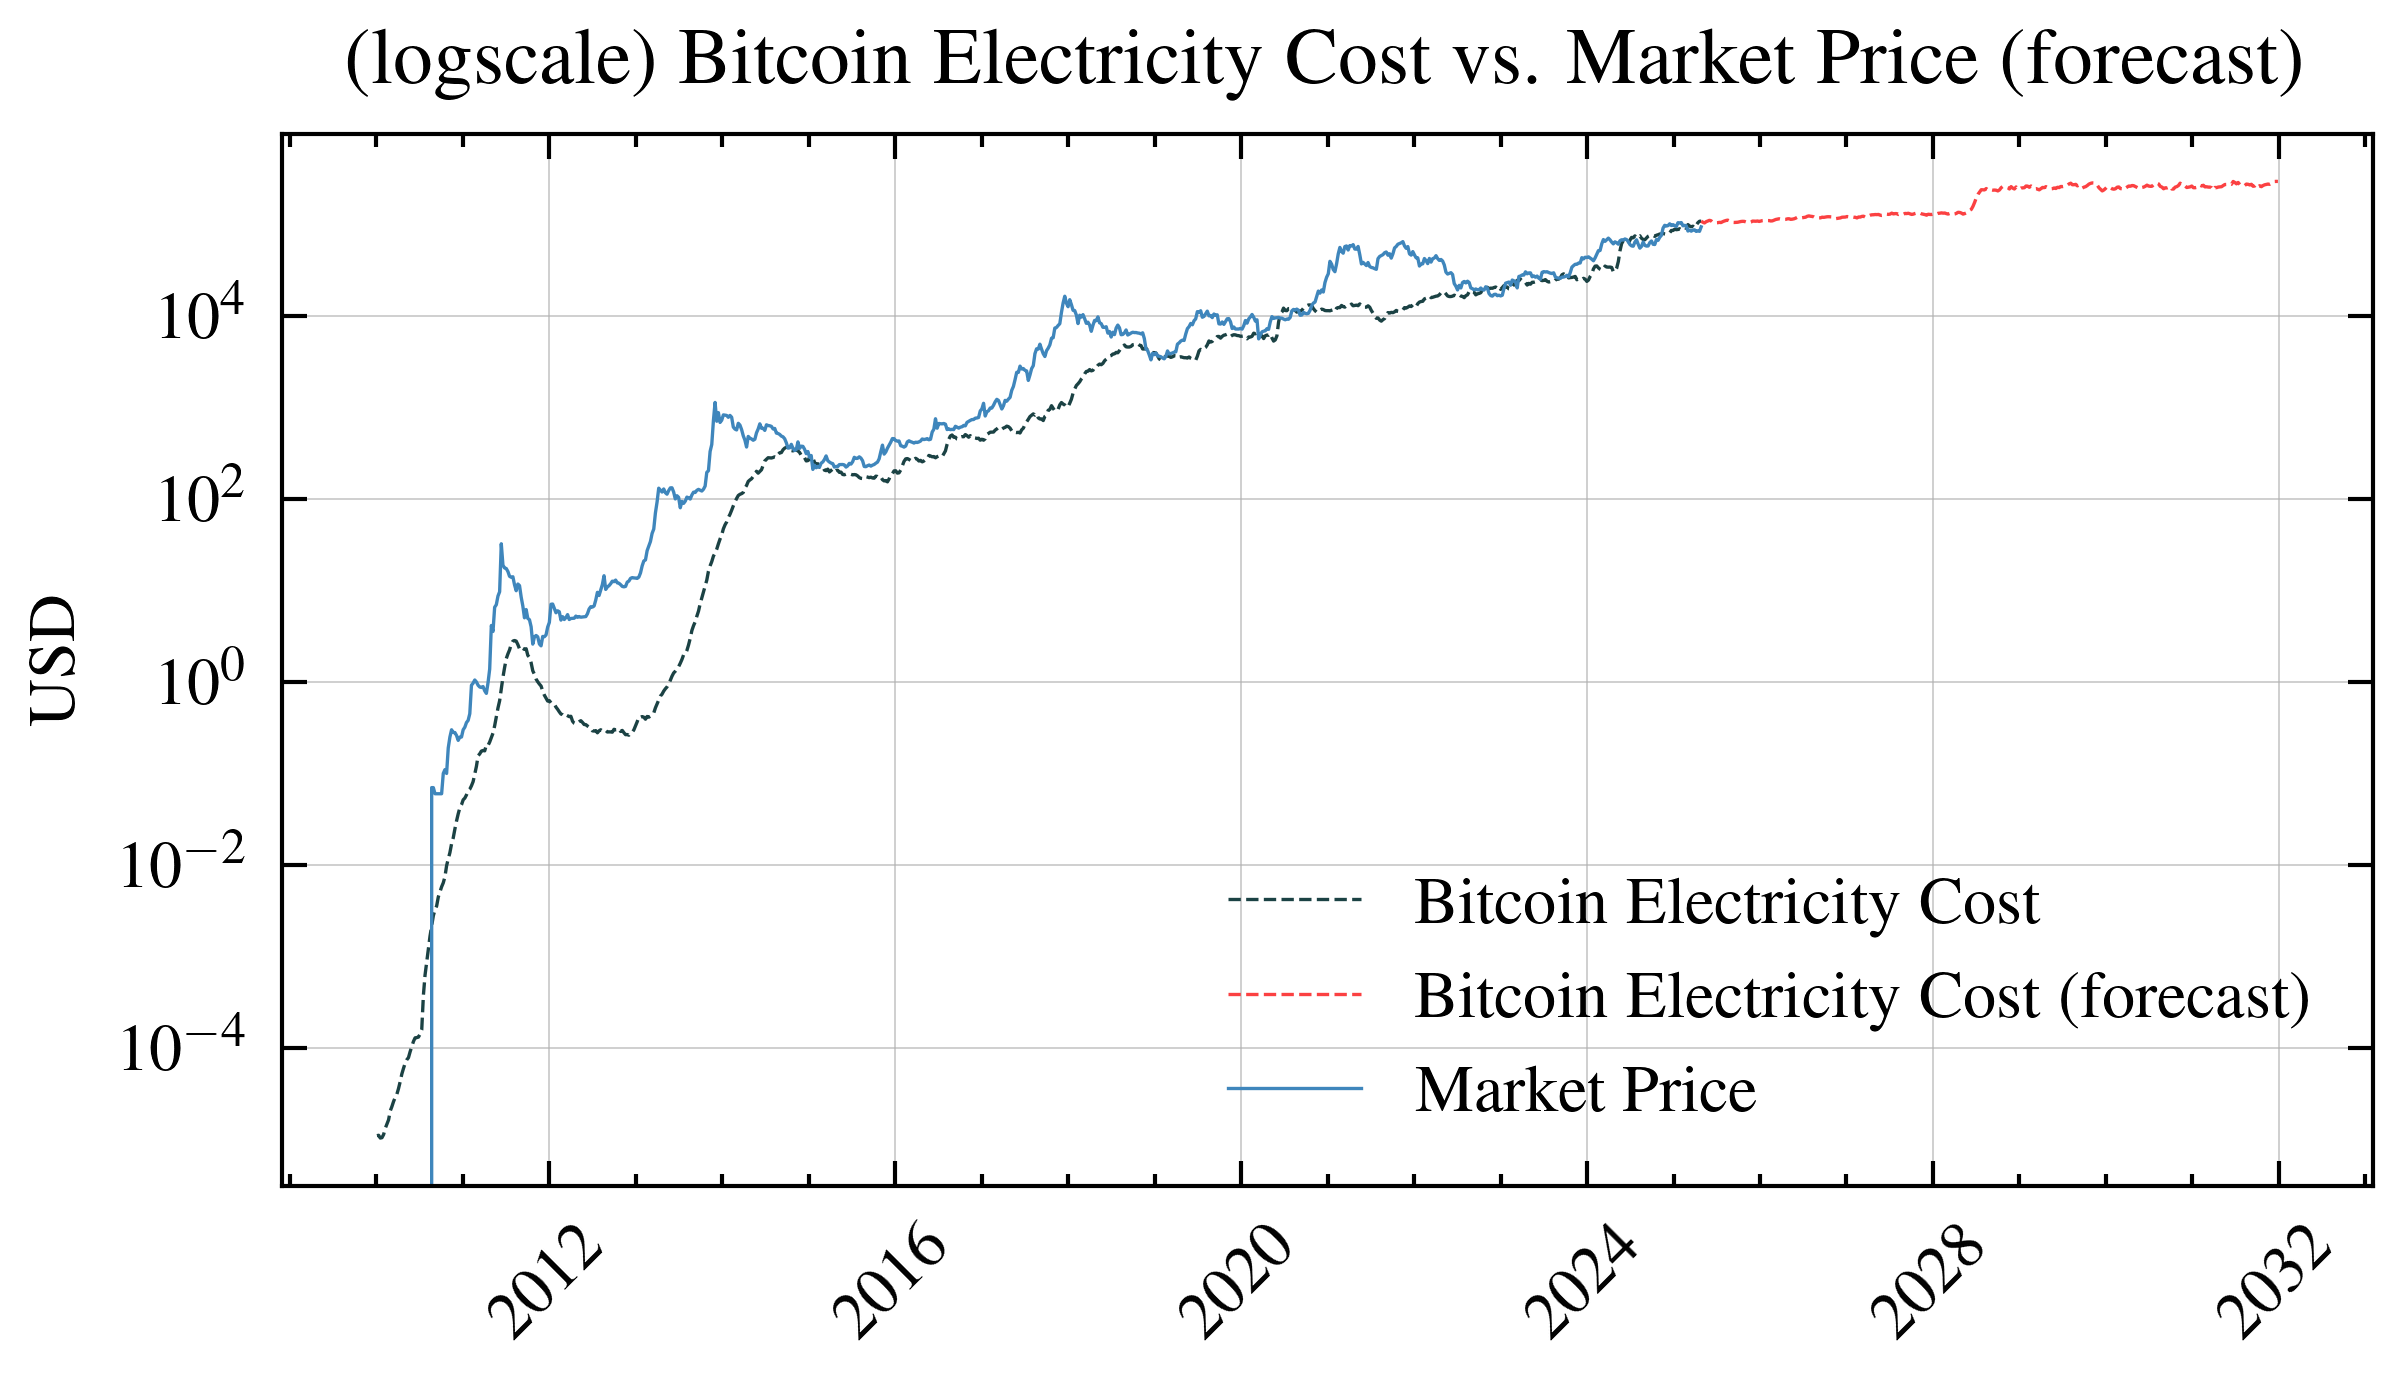

In [55]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecast2.png')
    plt.show()

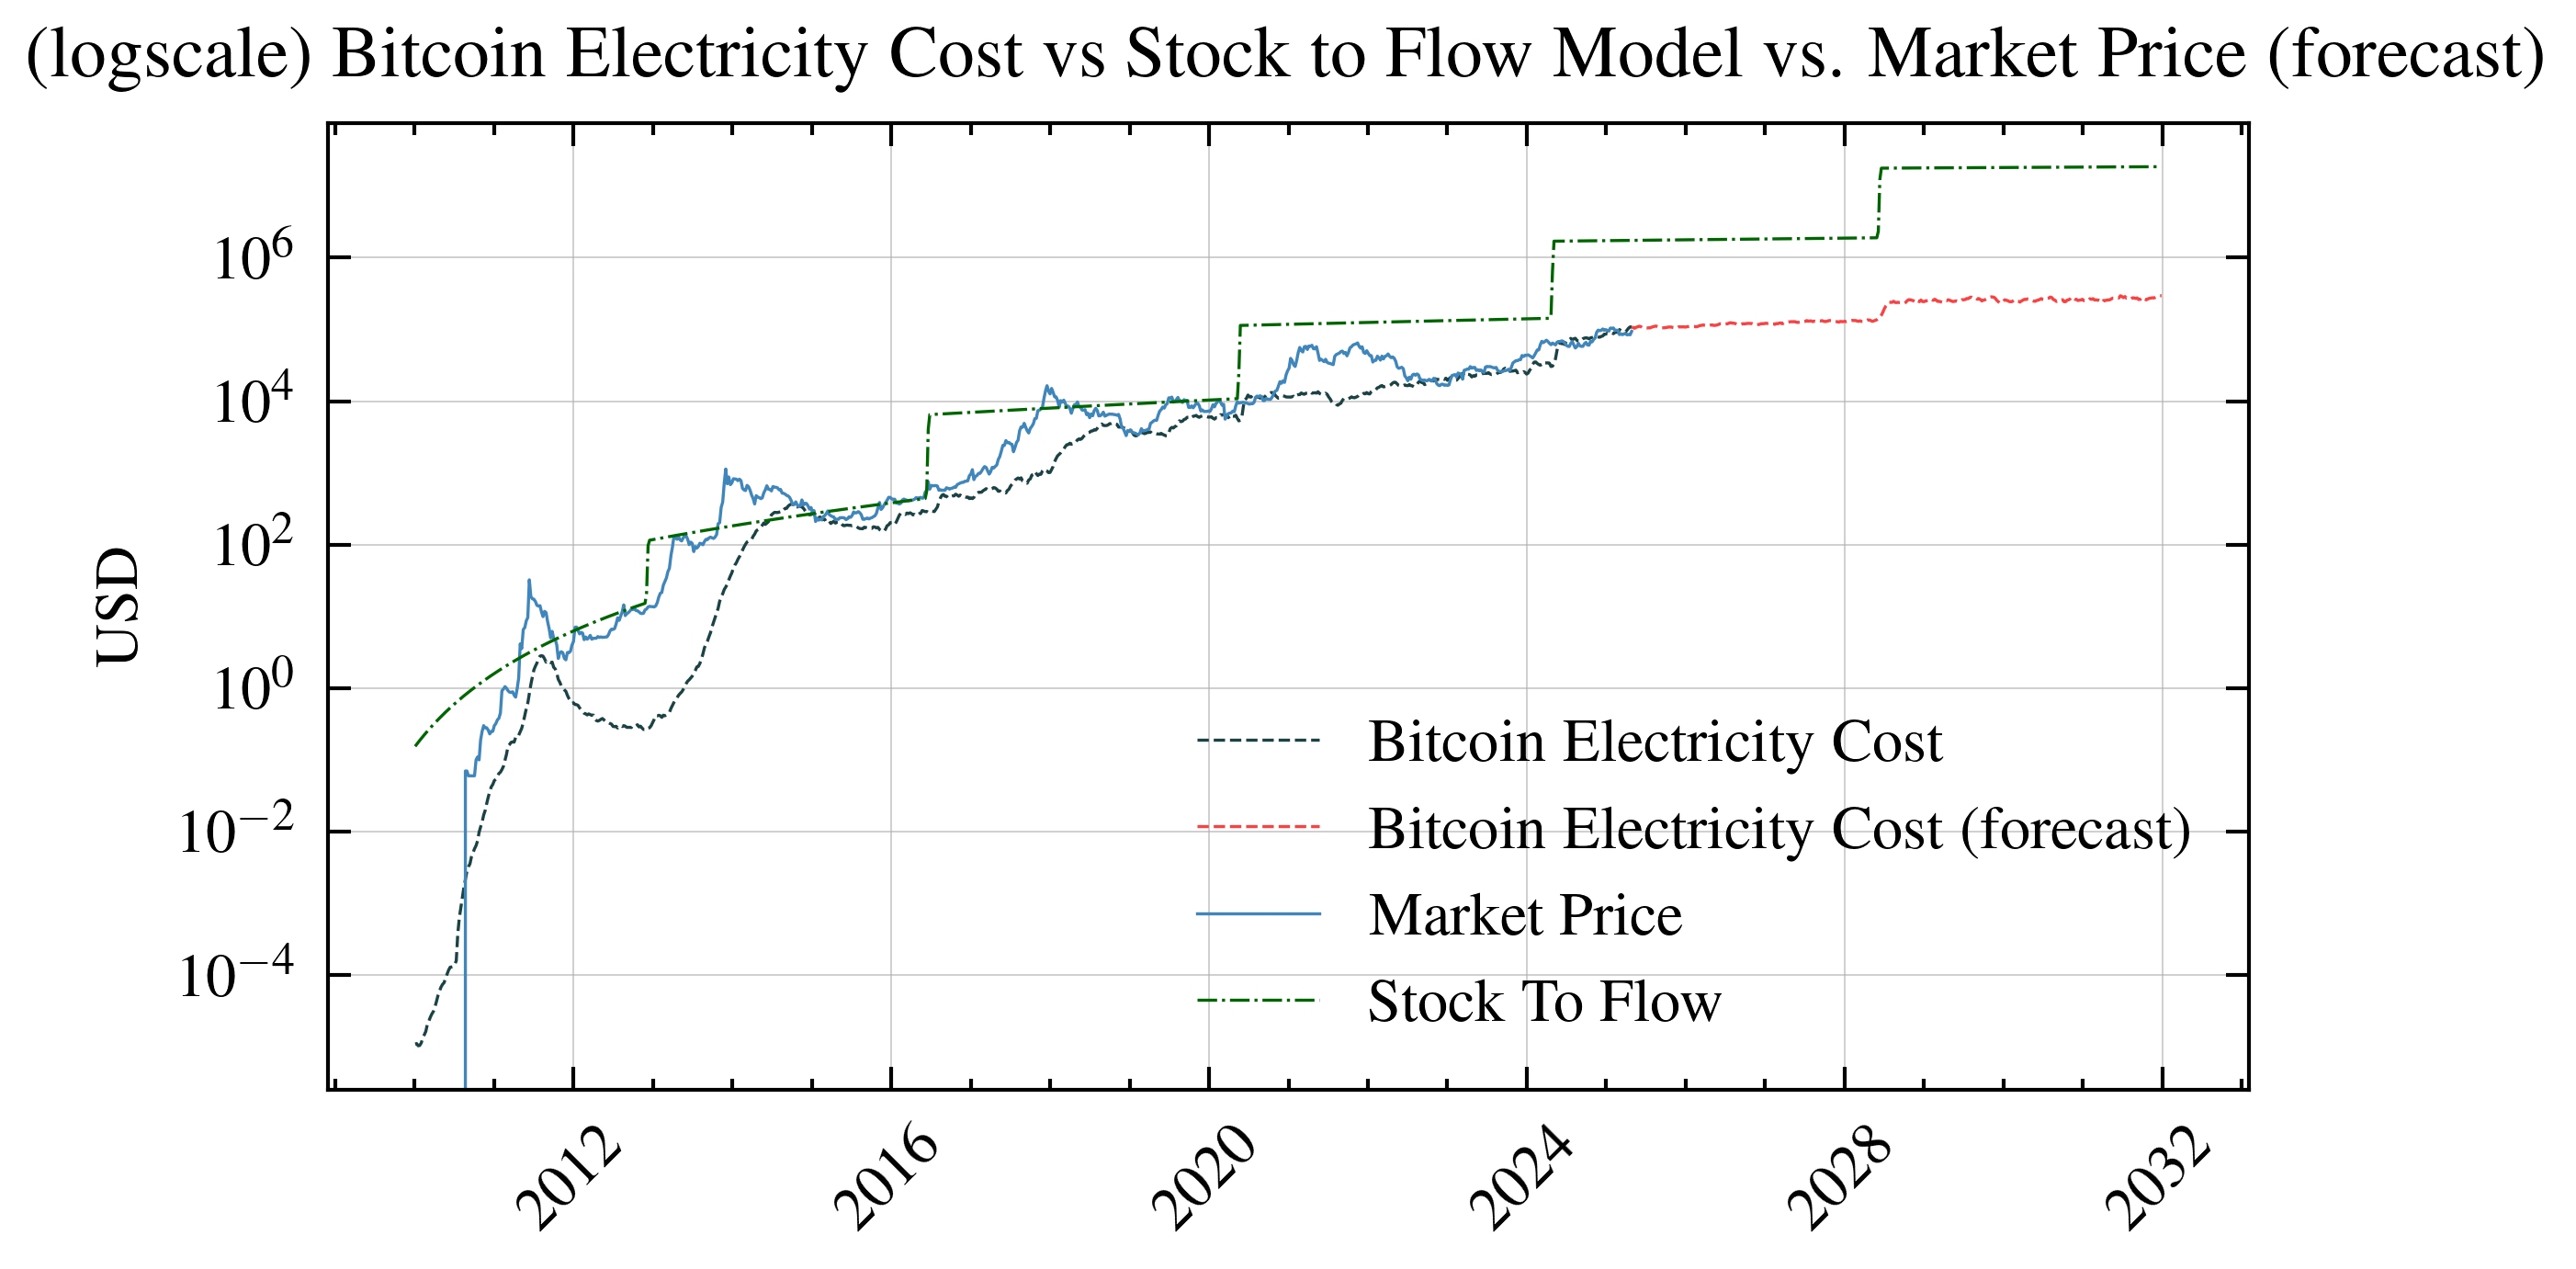

In [56]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs Stock to Flow Model vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecaststf1.png')
    plt.show()

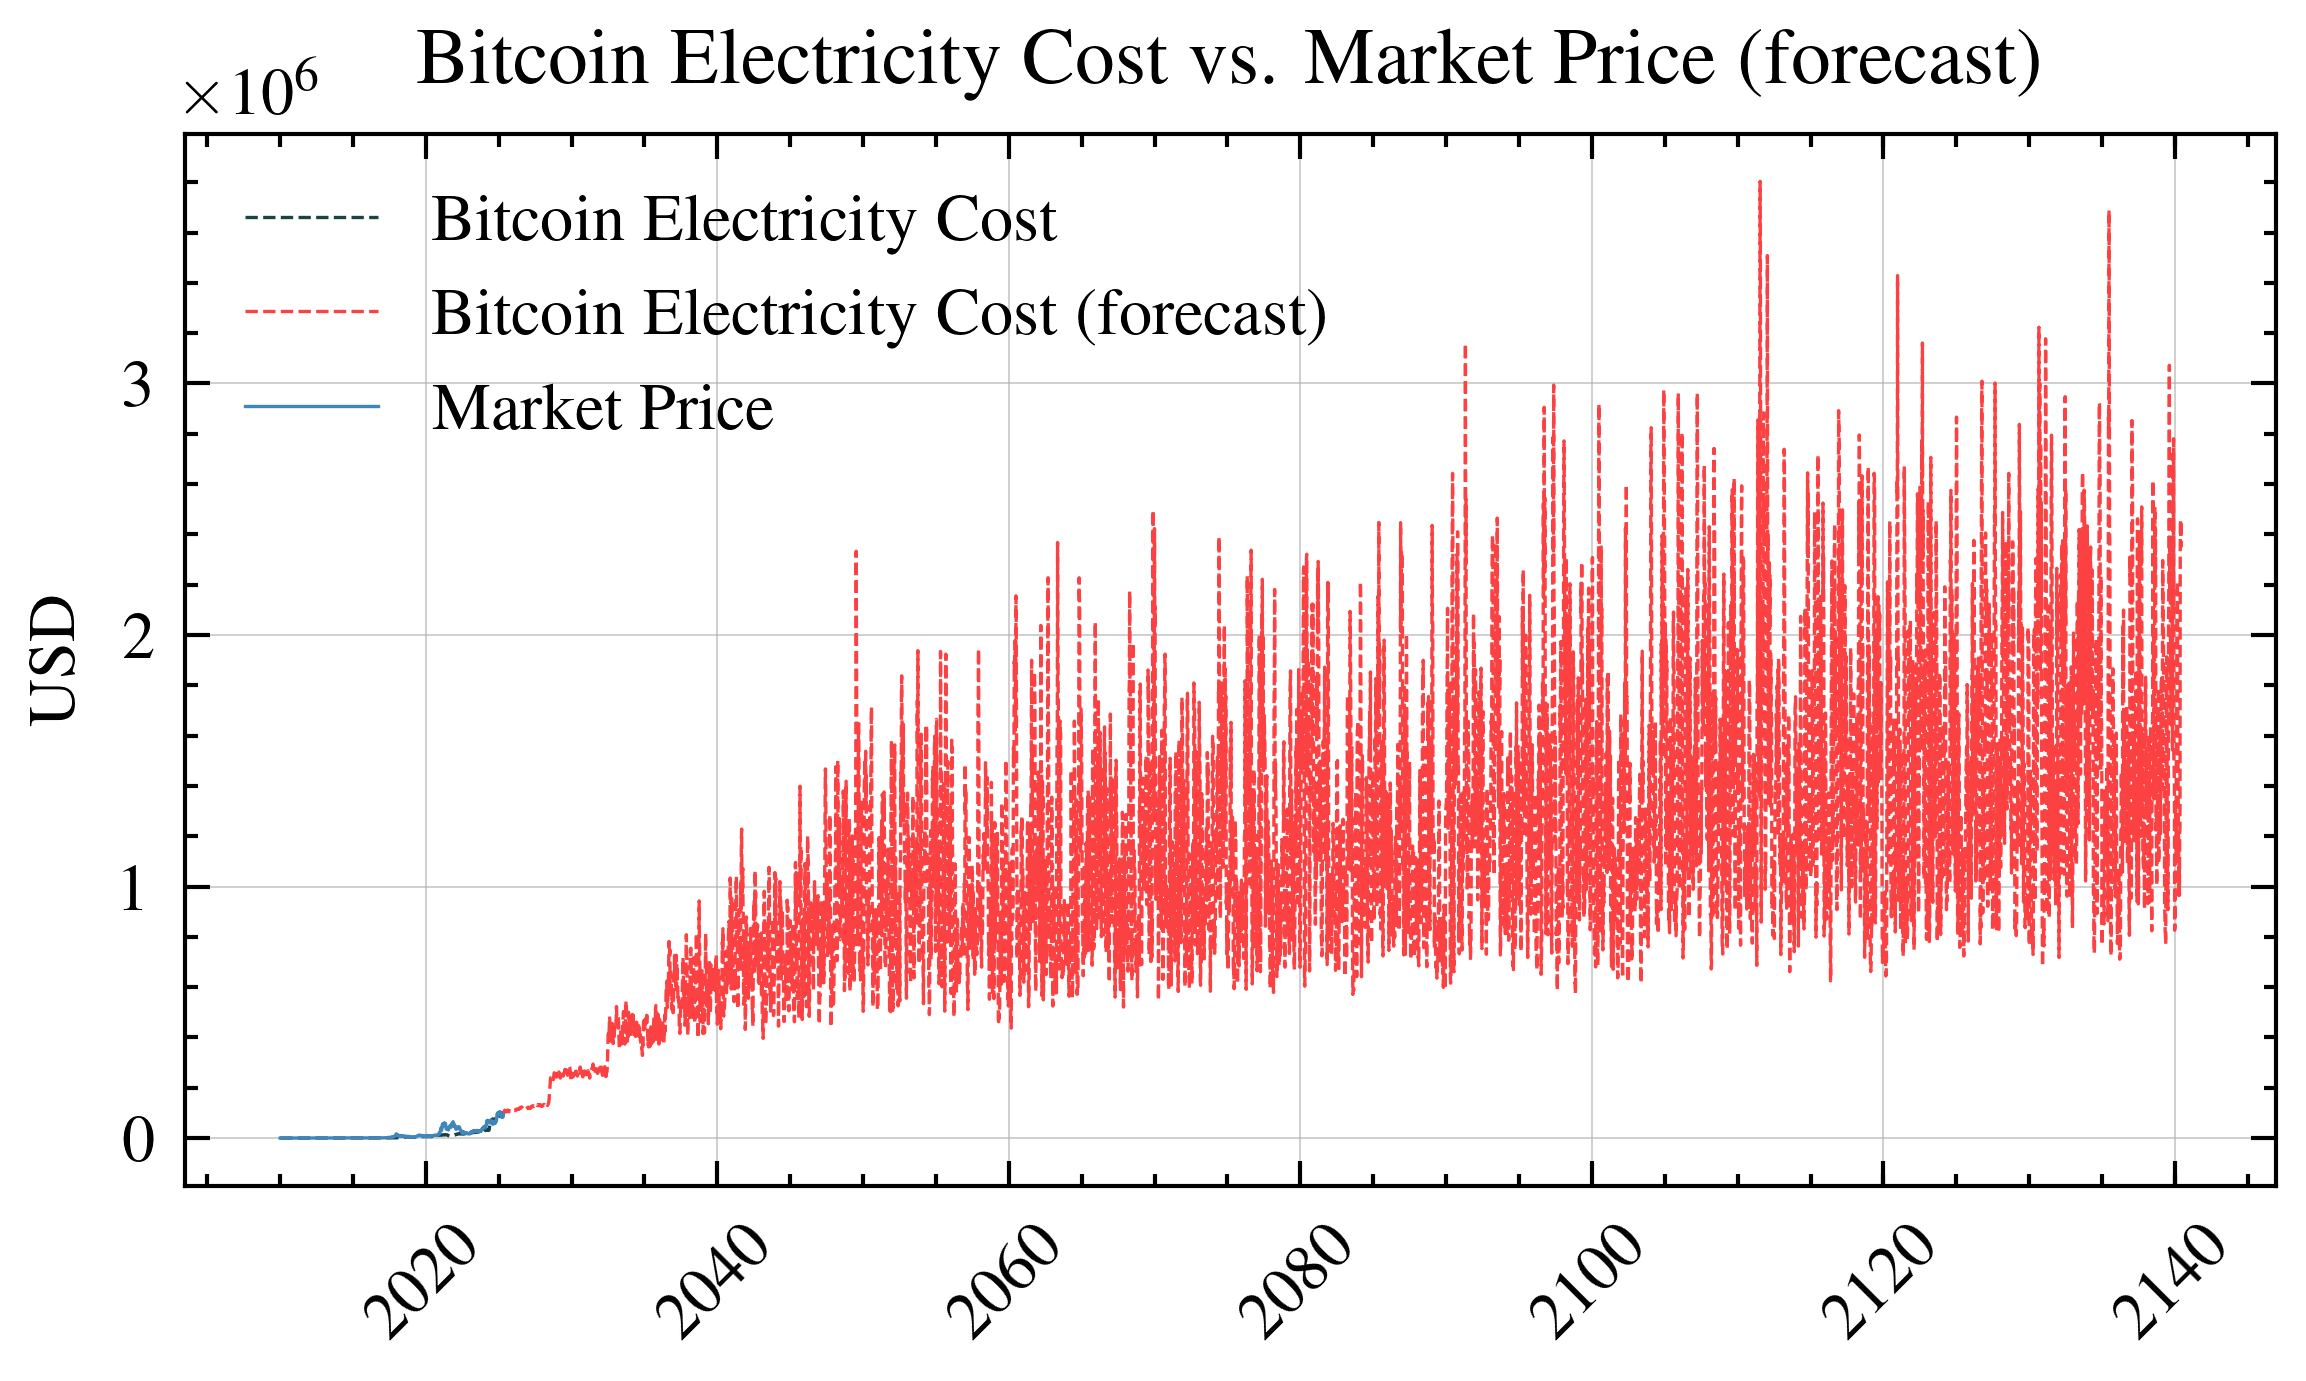

In [57]:
df_filtered = main_df['2010-01-01':'2232-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
 #   plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast3.png')
    plt.show()

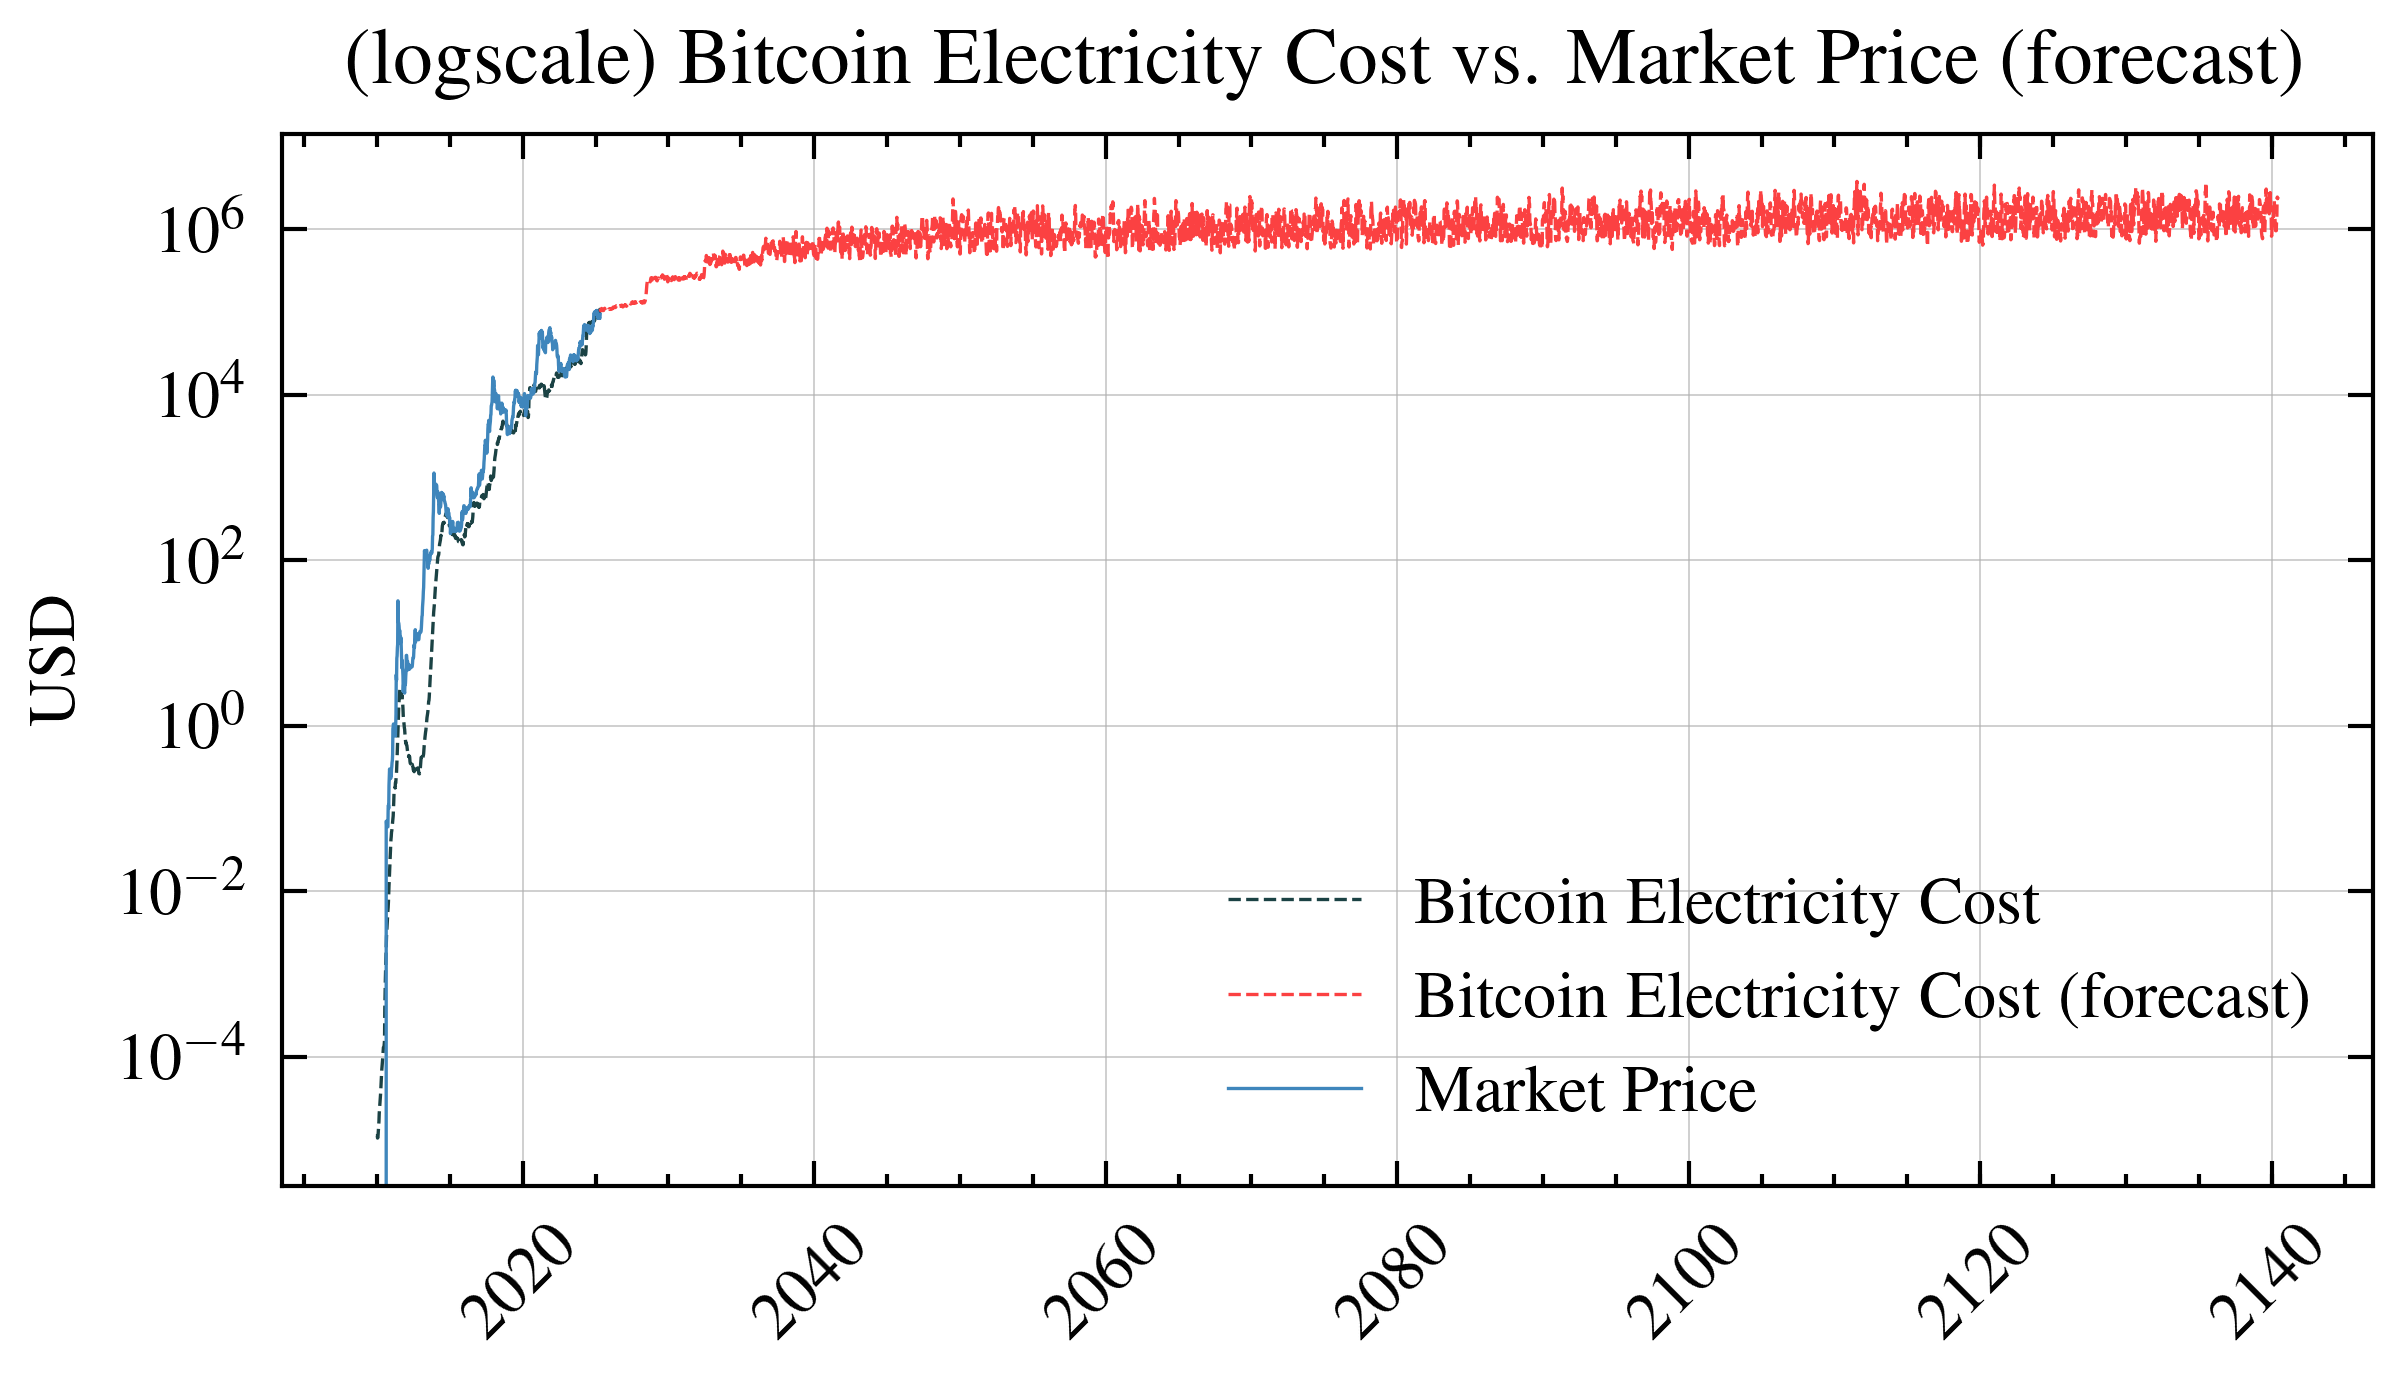

In [58]:
df_filtered = main_df['2010-01-01':'2232-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecast4.png')
    plt.show()

C:\Users\pkapl\AppData\Local\Temp\ipykernel_12528\1436072276.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(df_filtered[:df.index[-1]].index[-1].strftime('%Y-%m (week %V)') +', ECM:'+f'{df_filtered[:df.index[-1]]['mining_cost'][-1]:.0f}'+' USD, PRICE:'  f'{df_filtered[:df.index[-1]]['market_price'][-1]:.0f}' + ' USD')


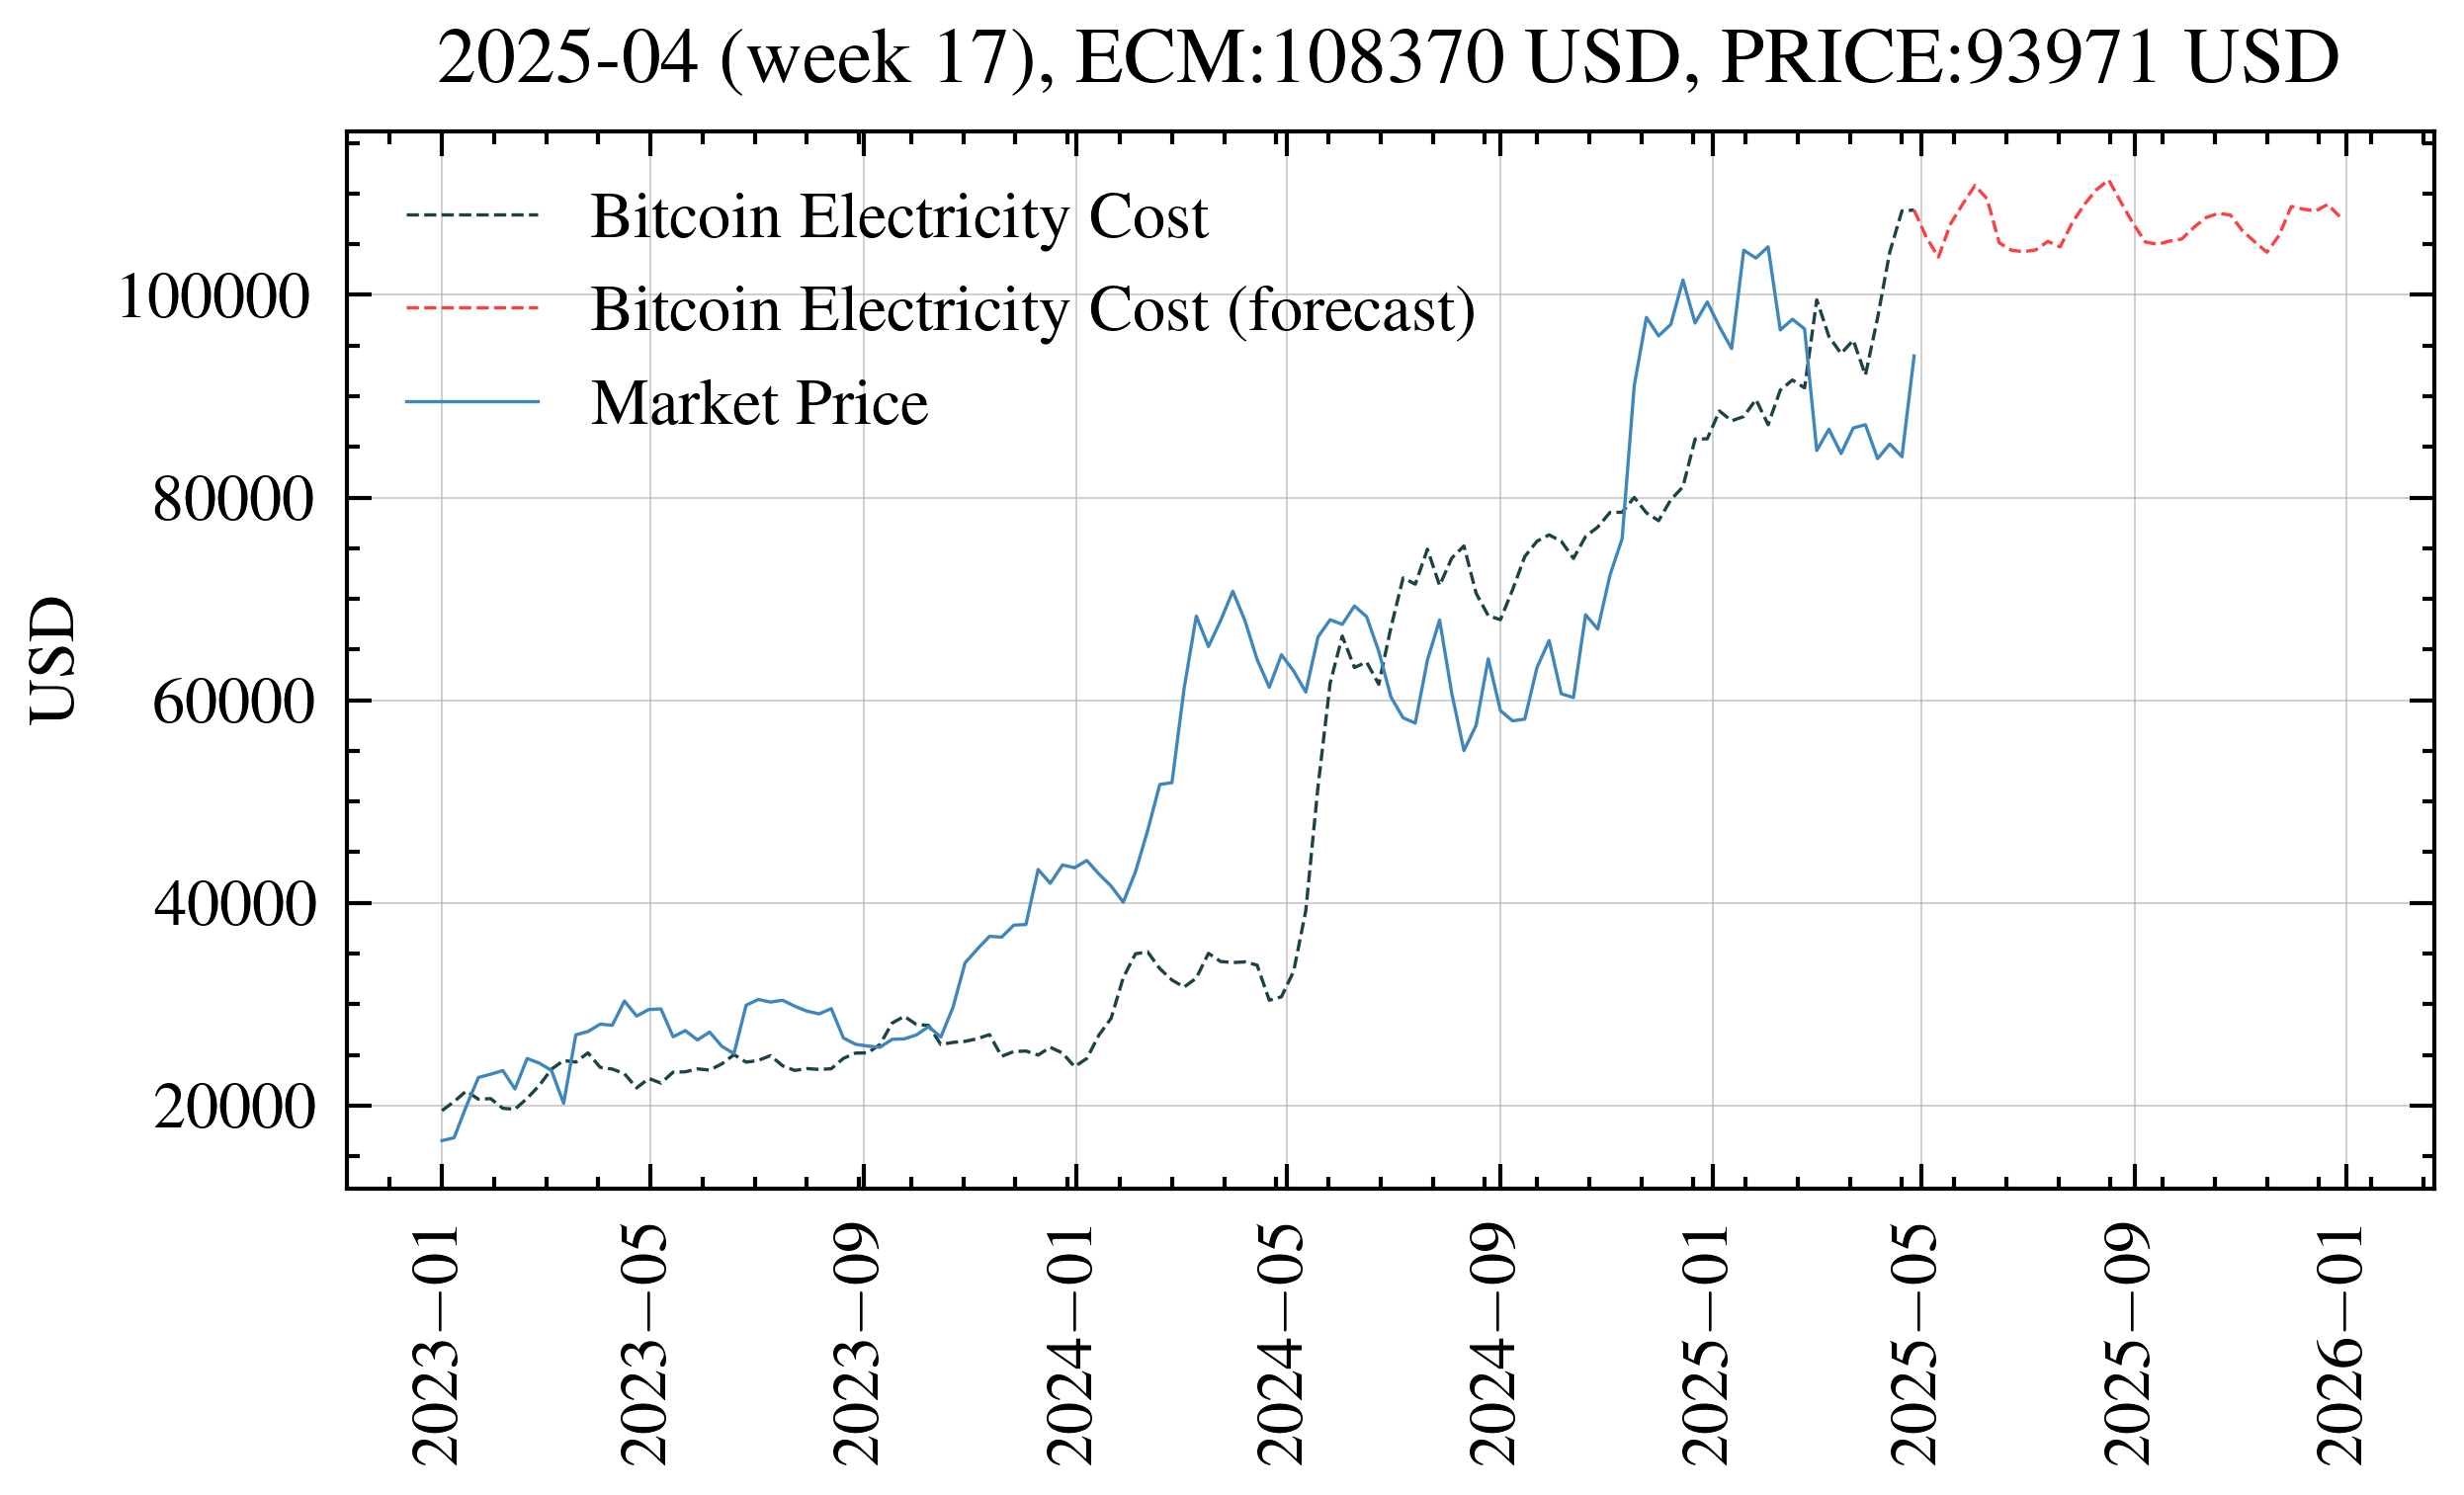

In [59]:
df_filtered = main_df['2023-01-01':'2026-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('USD')
    plt.title(df_filtered[:df.index[-1]].index[-1].strftime('%Y-%m (week %V)') +', ECM:'+f'{df_filtered[:df.index[-1]]['mining_cost'][-1]:.0f}'+' USD, PRICE:'  f'{df_filtered[:df.index[-1]]['market_price'][-1]:.0f}' + ' USD')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast5.png')
    plt.show()

In [60]:
df_filtered[:df.index[-1]].index[-1].strftime('%Y-%m') +', ECM:'+f'{df_filtered[:df.index[-1]]['mining_cost'][-1]:.2f}'+' USD, PRICE:'  f'{df_filtered[:df.index[-1]]['market_price'][-1]:.2f}' + ' USD'

C:\Users\pkapl\AppData\Local\Temp\ipykernel_12528\1074661667.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_filtered[:df.index[-1]].index[-1].strftime('%Y-%m') +', ECM:'+f'{df_filtered[:df.index[-1]]['mining_cost'][-1]:.2f}'+' USD, PRICE:'  f'{df_filtered[:df.index[-1]]['market_price'][-1]:.2f}' + ' USD'


'2025-04, ECM:108370.10 USD, PRICE:93970.77 USD'

In [61]:
import datetime

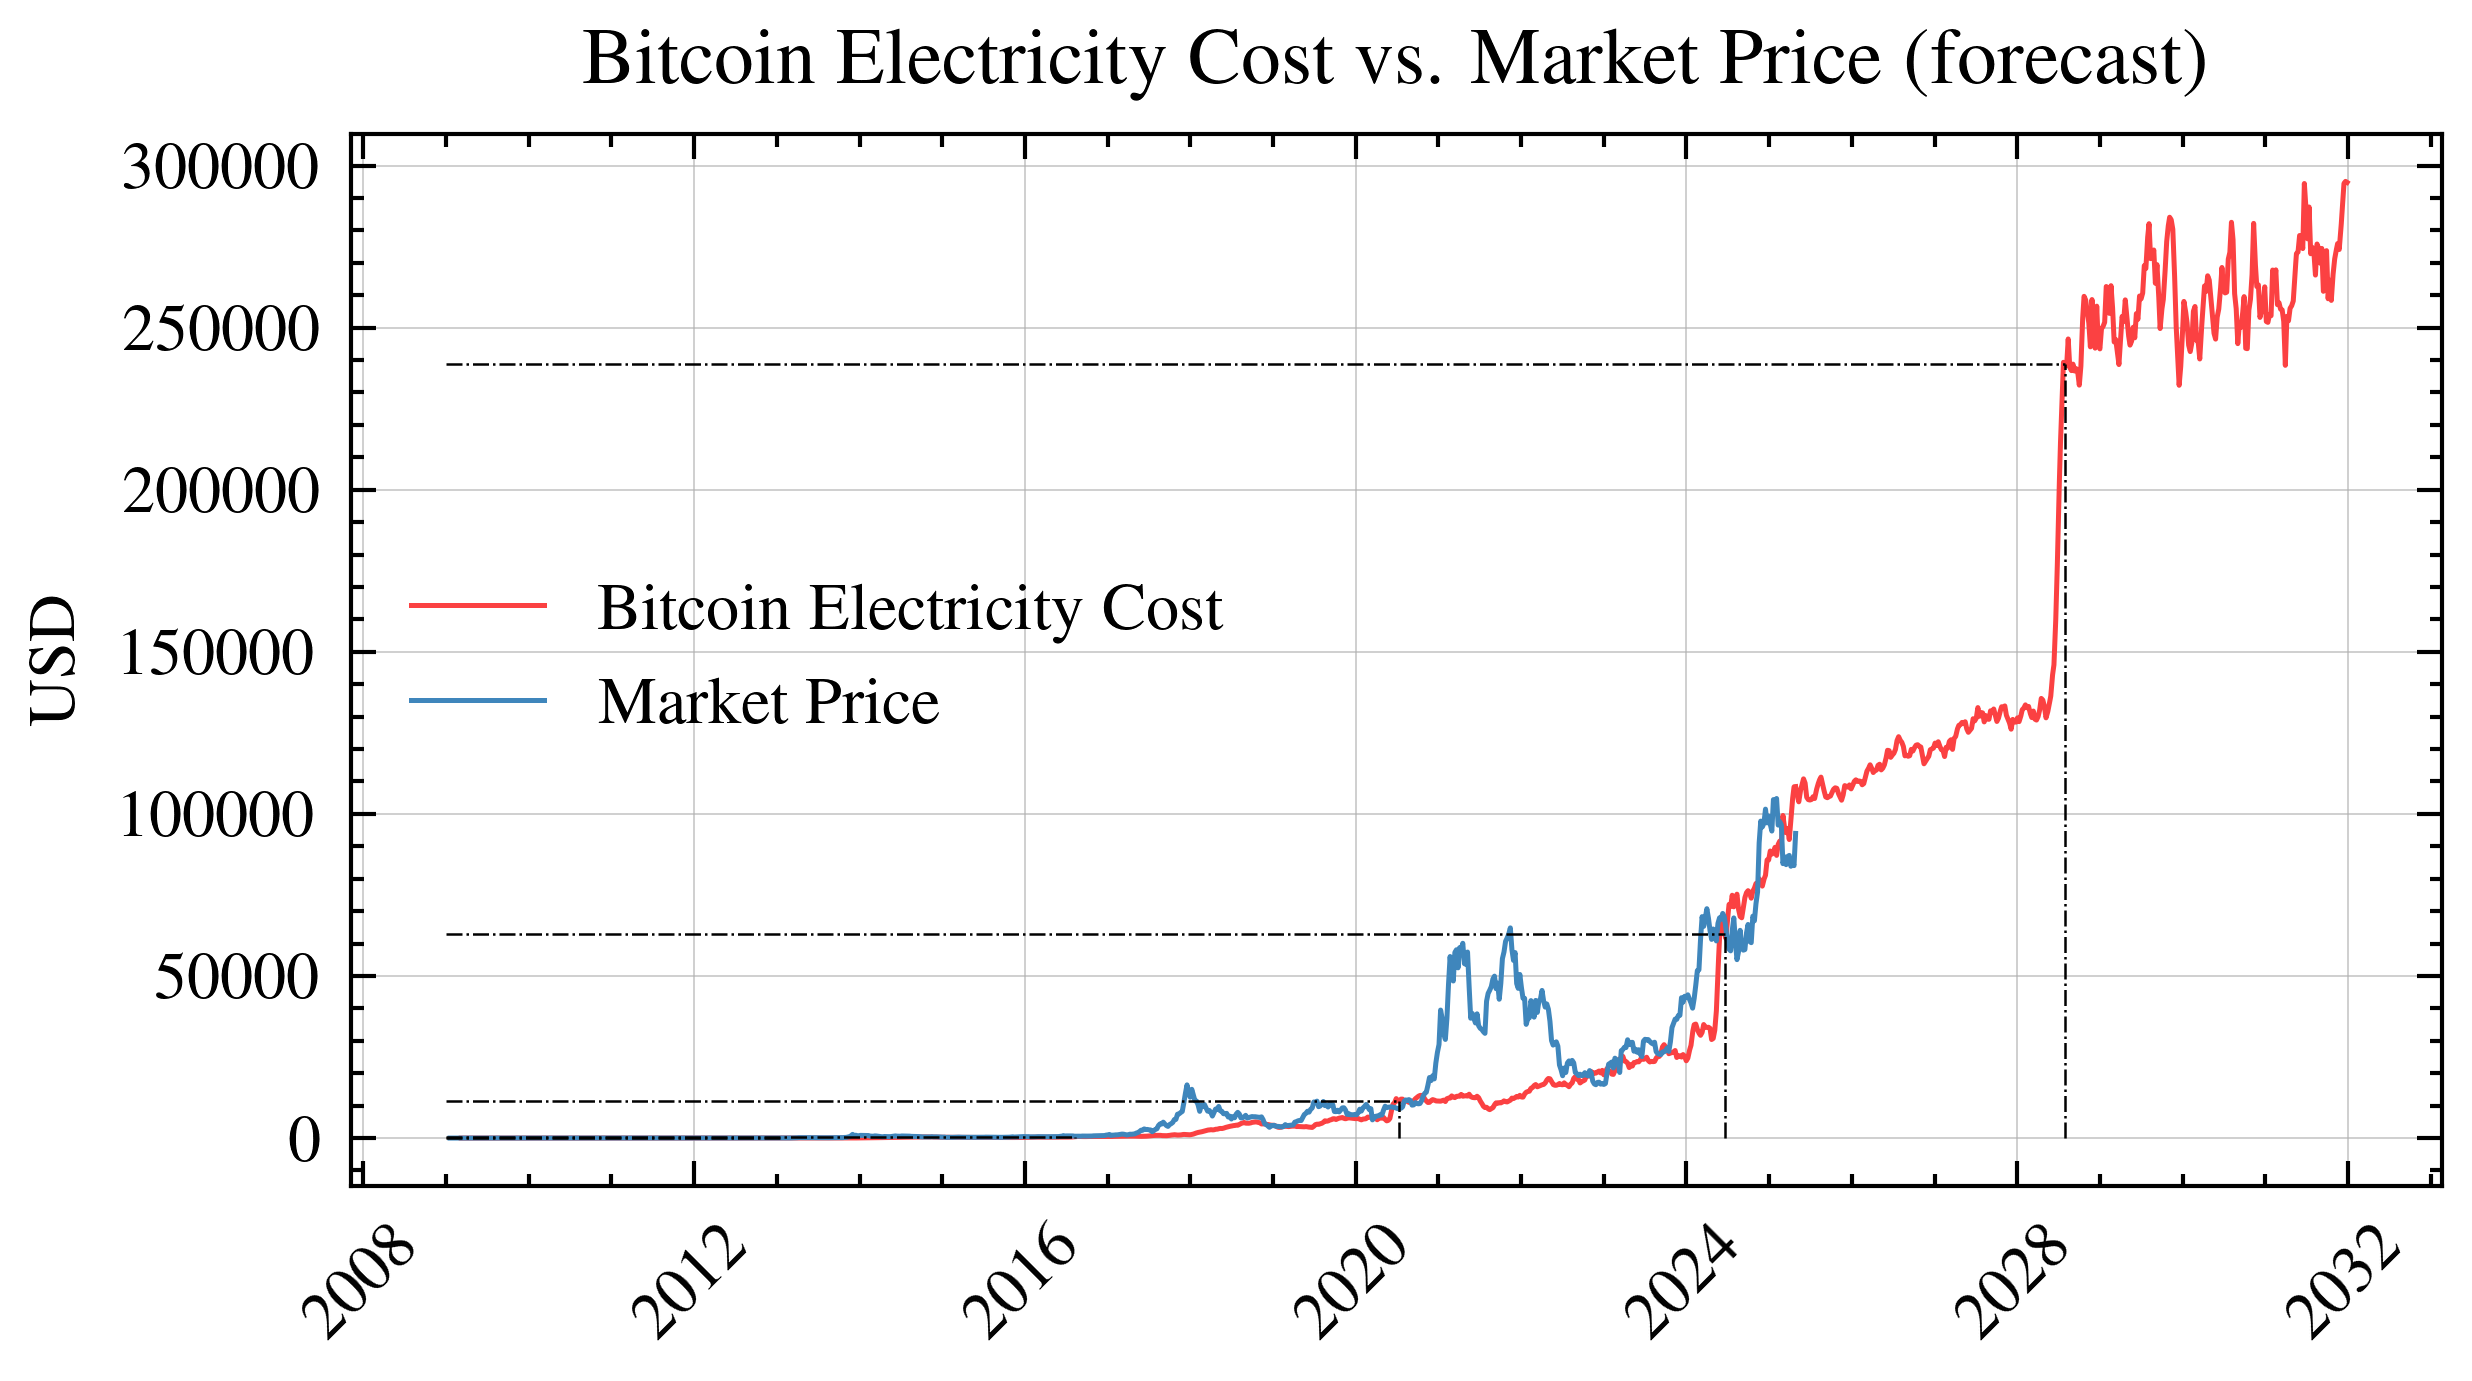

In [62]:
start_date = '2009-01-01'
end_date = '2032-01-01'
df_nfiltered = main_df[start_date:end_date].copy()
df_filtered = main_df[start_date:end_date].copy().resample('D').interpolate('linear')
halvings = simulated_bitcoins_lores[start_date:end_date].index
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_nfiltered.index, df_nfiltered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.6)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    for halving in halvings:
        tm =  halving+ datetime.timedelta(days=60)
        vl =  df_filtered.loc[tm]['mining_cost']
        plt.plot([pd.to_datetime(start_date),tm], [vl,vl], color='black',  linestyle='-.', linewidth=0.3)
        plt.vlines(tm,0,vl, colors='black', linestyles='-.', linewidth=0.3)

    plt.ylabel('USD')
    plt.title('Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecaststf2.png')
    plt.show()

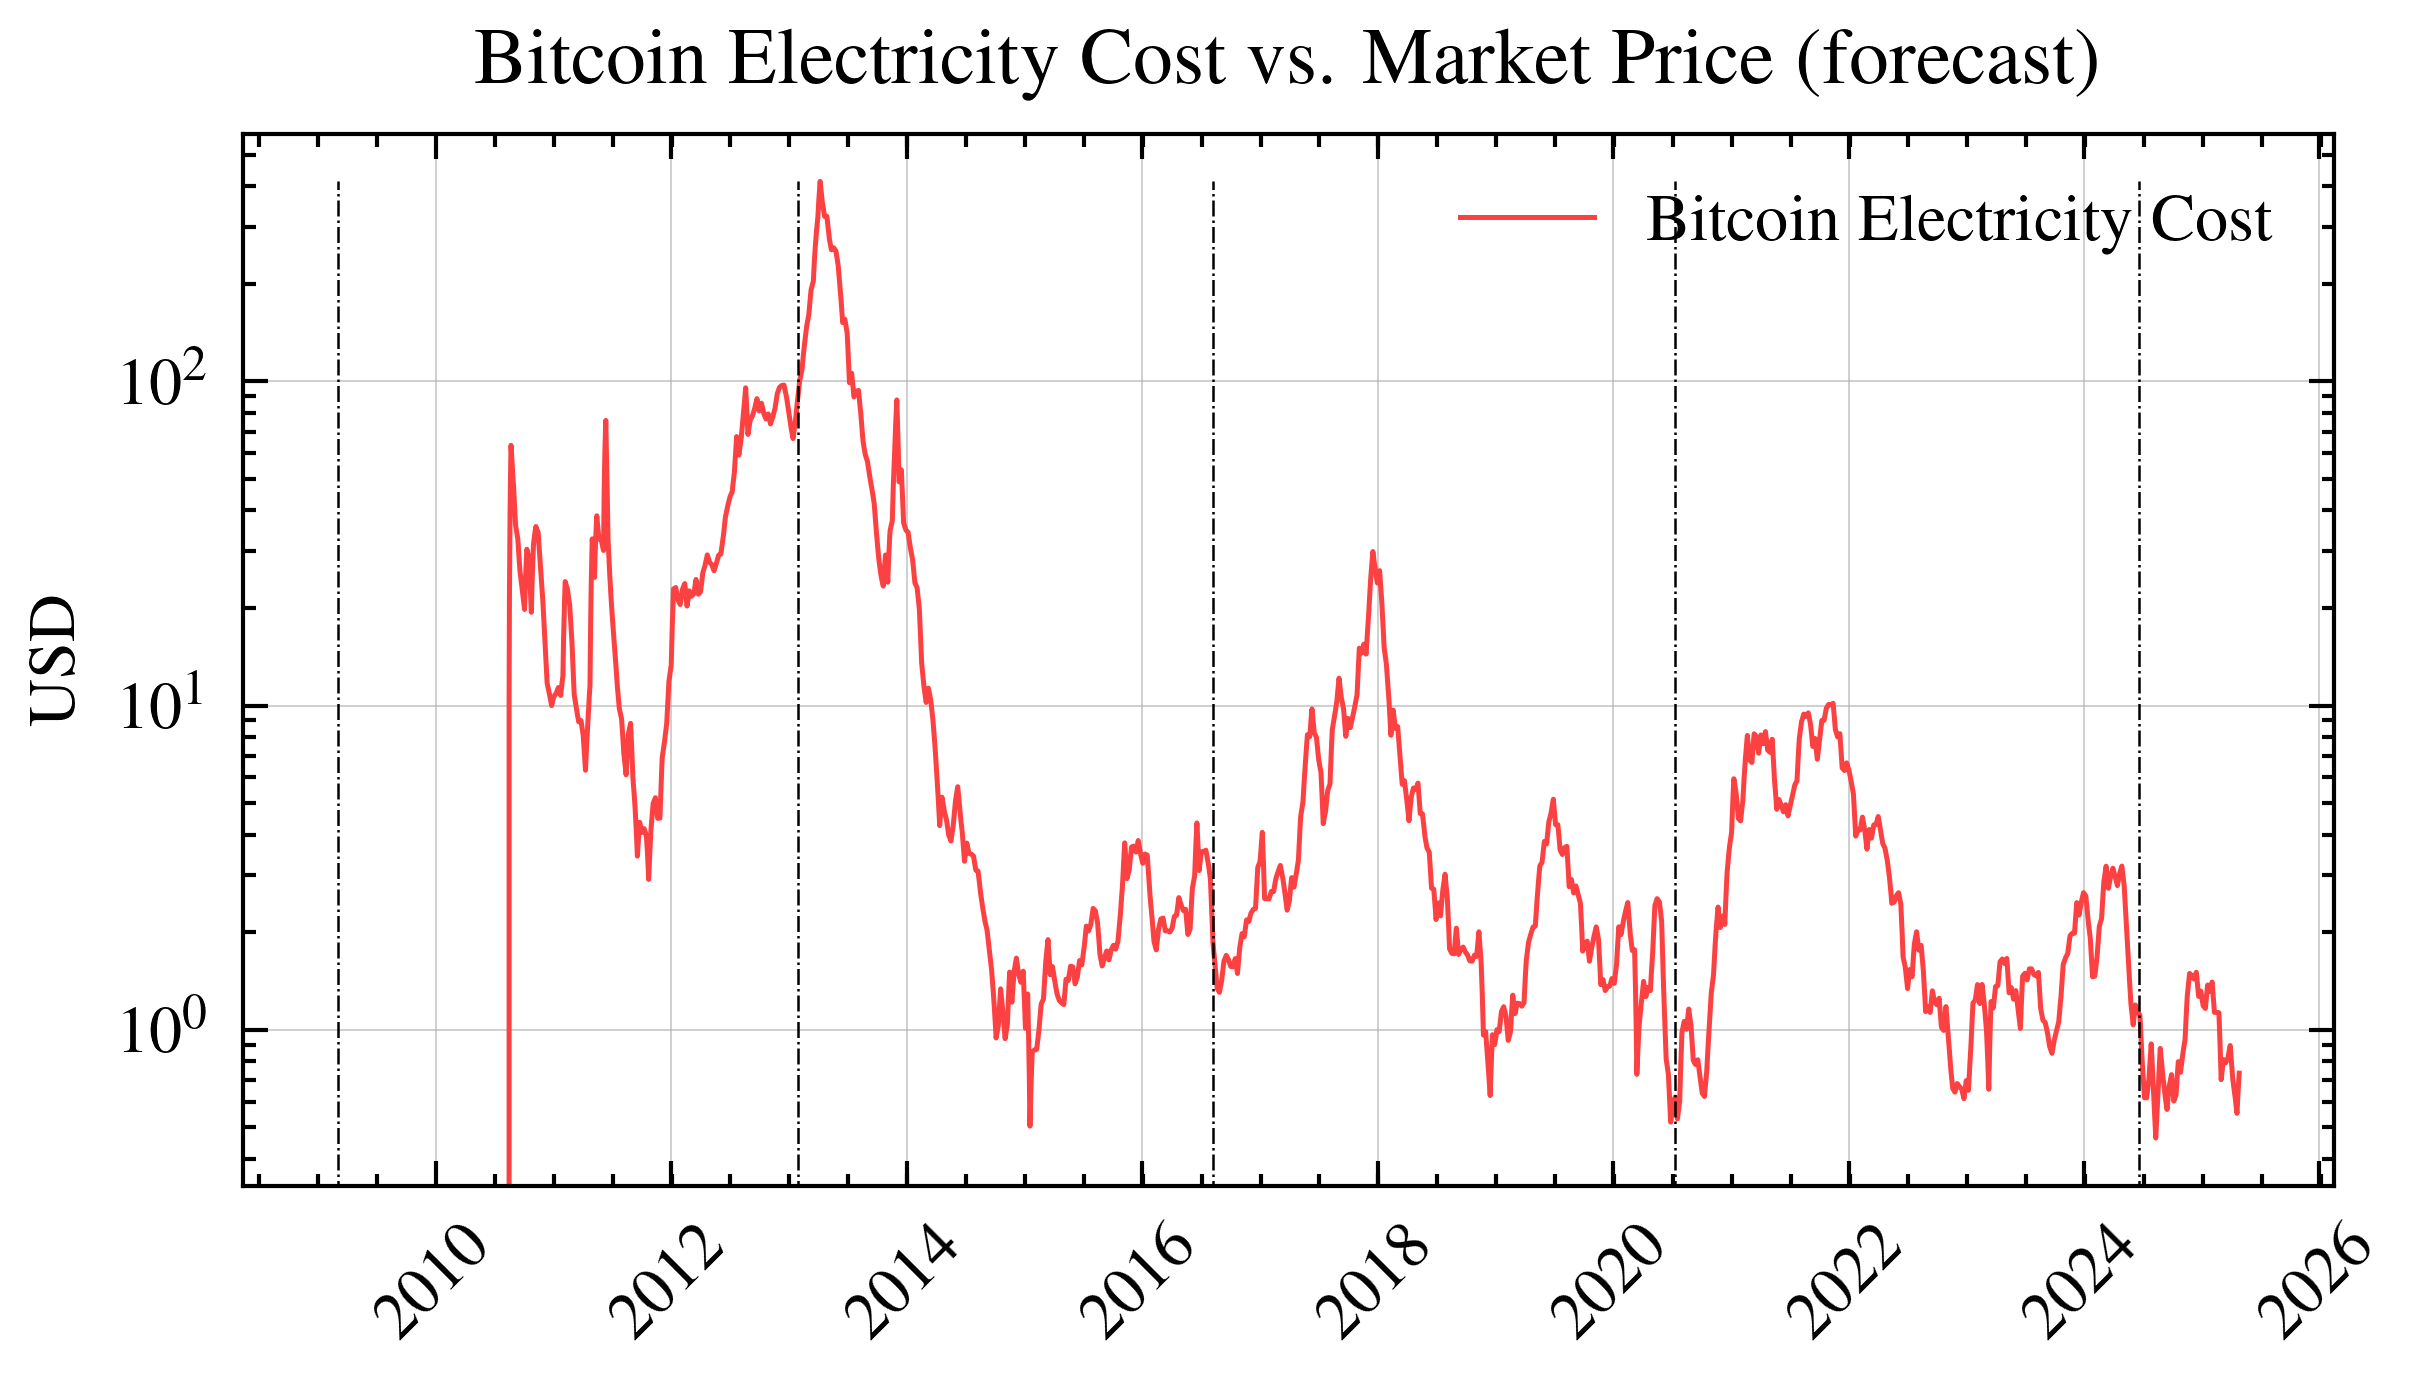

In [63]:
start_date = '2009-01-01'
end_date = df.index[-1]
df_nfiltered = main_df[start_date:end_date].copy()
df_filtered = main_df[start_date:end_date].copy().resample('D').interpolate('linear')
df_filtered["delta"]=(df_filtered['market_price']*2-df_filtered['mining_cost'])/df_filtered['mining_cost']
halvings = simulated_bitcoins_lores[start_date:end_date].index
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.plot(df_filtered.index,df_filtered['delta'], label='Bitcoin Electricity Cost', color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    vl =  df_filtered['delta'].max()
    for halving in halvings:
        tm =  halving+ datetime.timedelta(days=60)
        plt.vlines(tm,0,vl, colors='black', linestyles='-.', linewidth=0.3)
    plt.yscale('log')
    plt.ylabel('USD')
    plt.title('Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecaststfdiff1.png')
    plt.show()

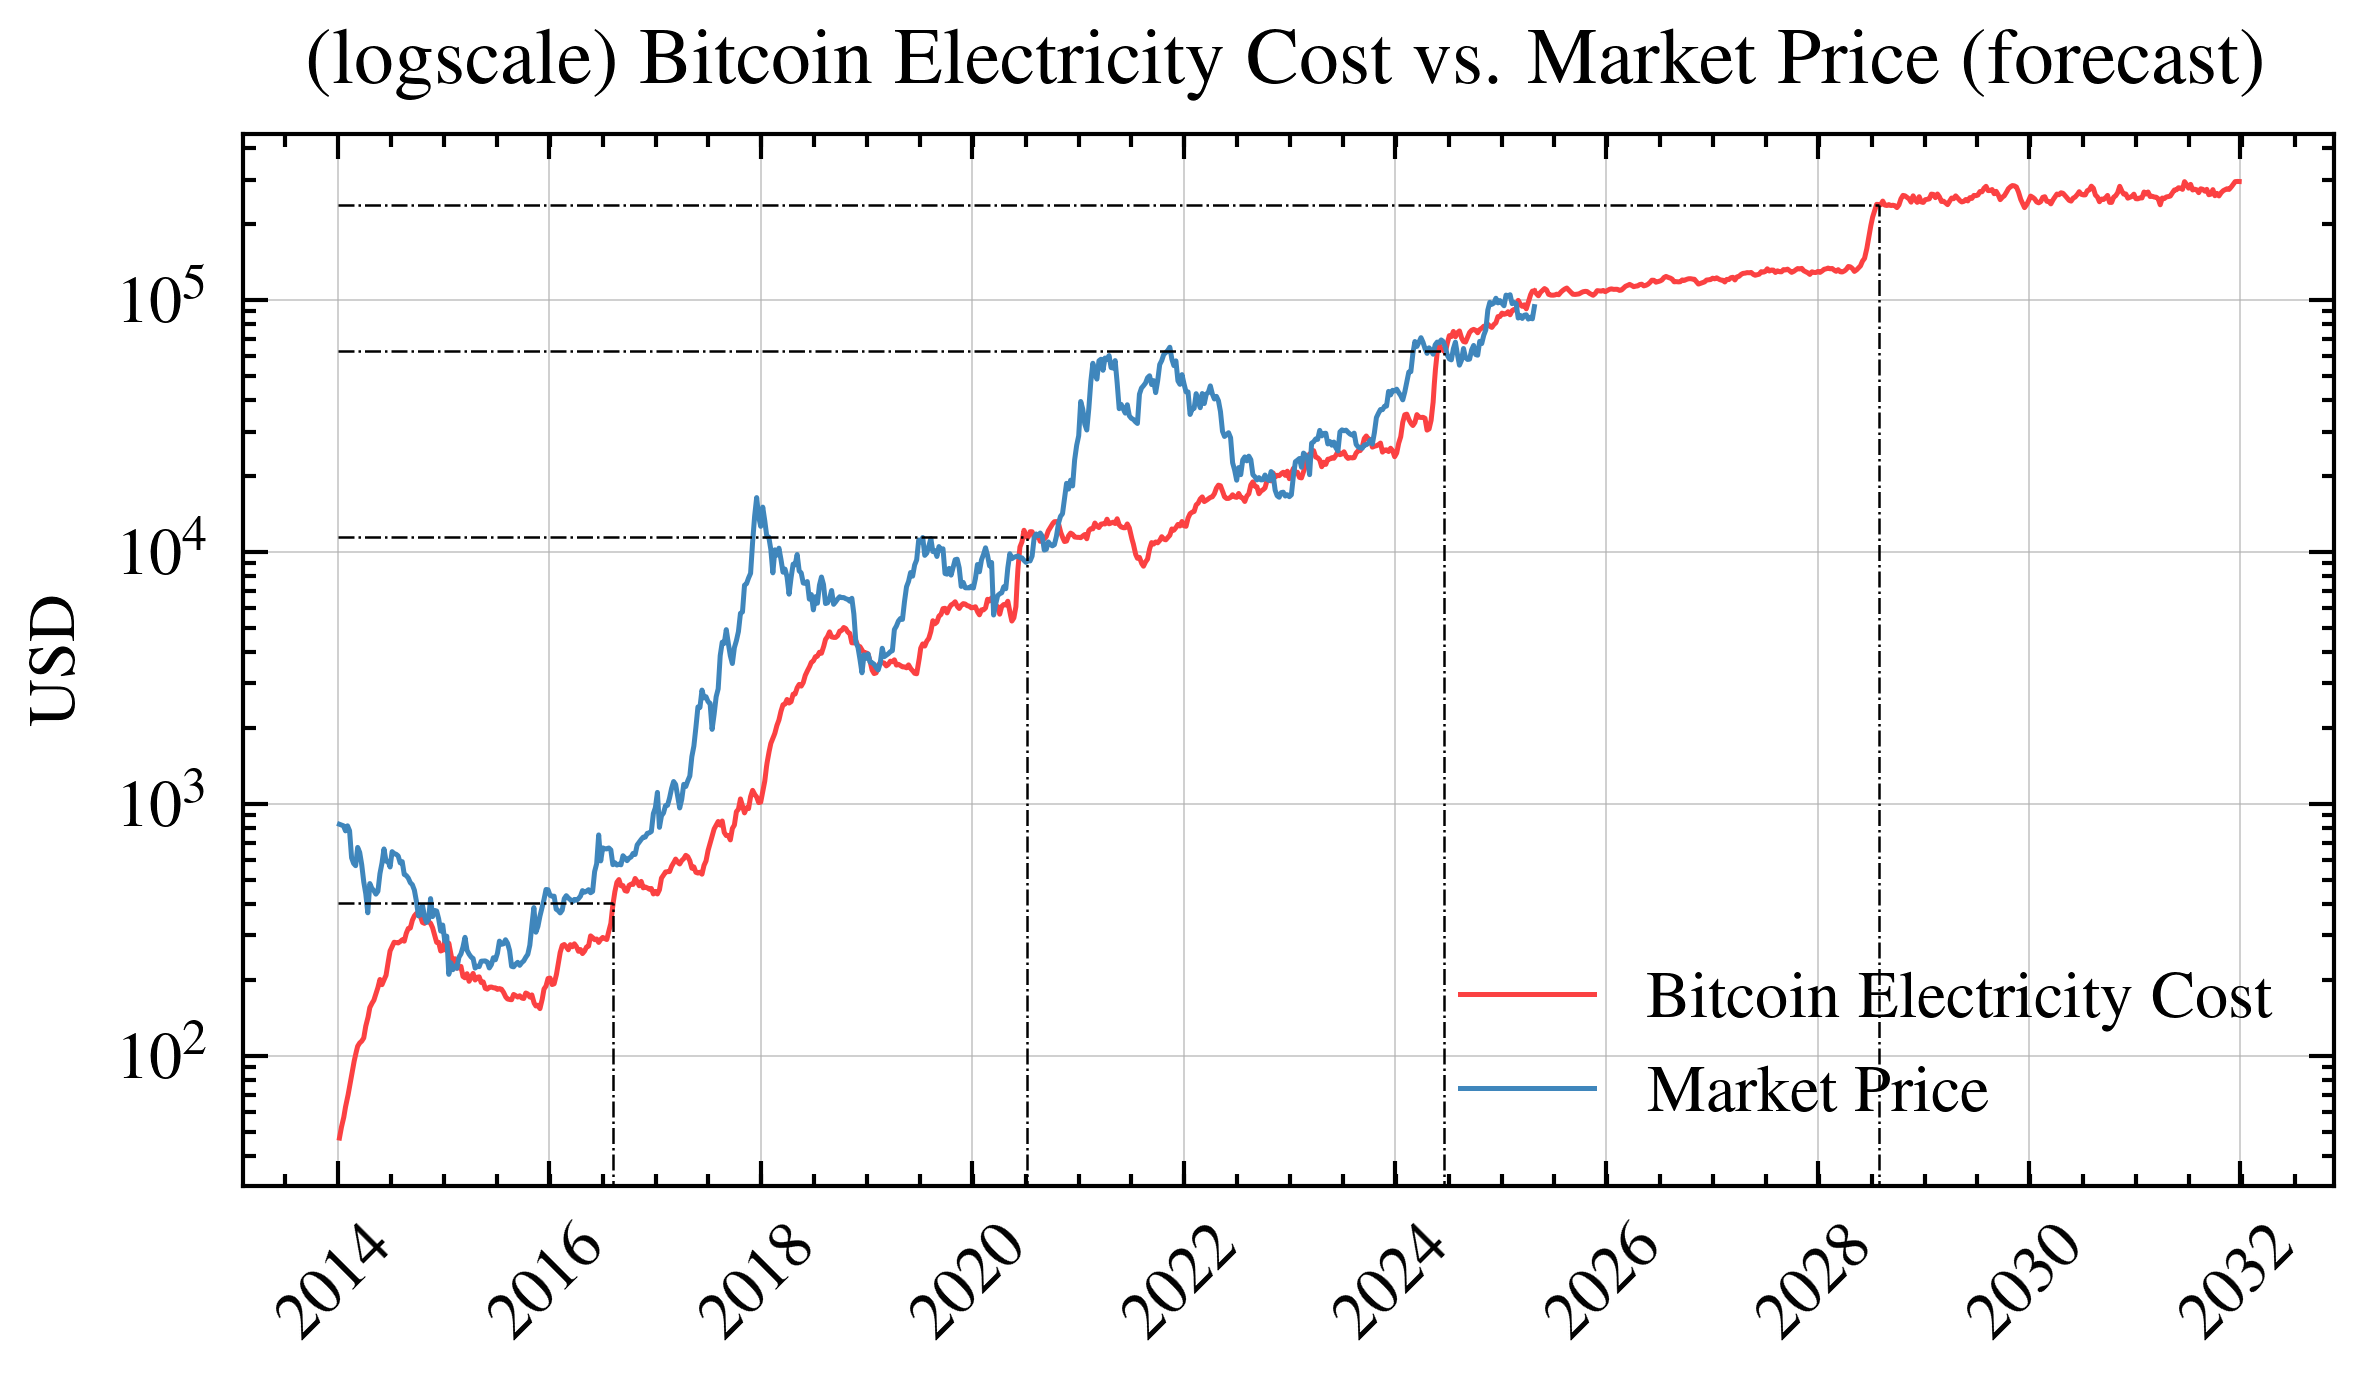

In [64]:
start_date = '2014-01-01'
end_date = '2032-01-01'
df_nfiltered = main_df[start_date:end_date].copy()
df_filtered = main_df[start_date:end_date].copy().resample('D').interpolate('linear')
halvings = simulated_bitcoins_lores[start_date:end_date].index
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_nfiltered.index, df_nfiltered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.6)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    for halving in halvings:
        tm =  halving+ datetime.timedelta(days=60)
        vl =  df_filtered.loc[tm]['mining_cost']
        plt.plot([pd.to_datetime(start_date),tm], [vl,vl], color='black',  linestyle='-.', linewidth=0.3)
        plt.vlines(tm,0,vl, colors='black', linestyles='-.', linewidth=0.3)

    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecaststf3.png')
    plt.show()

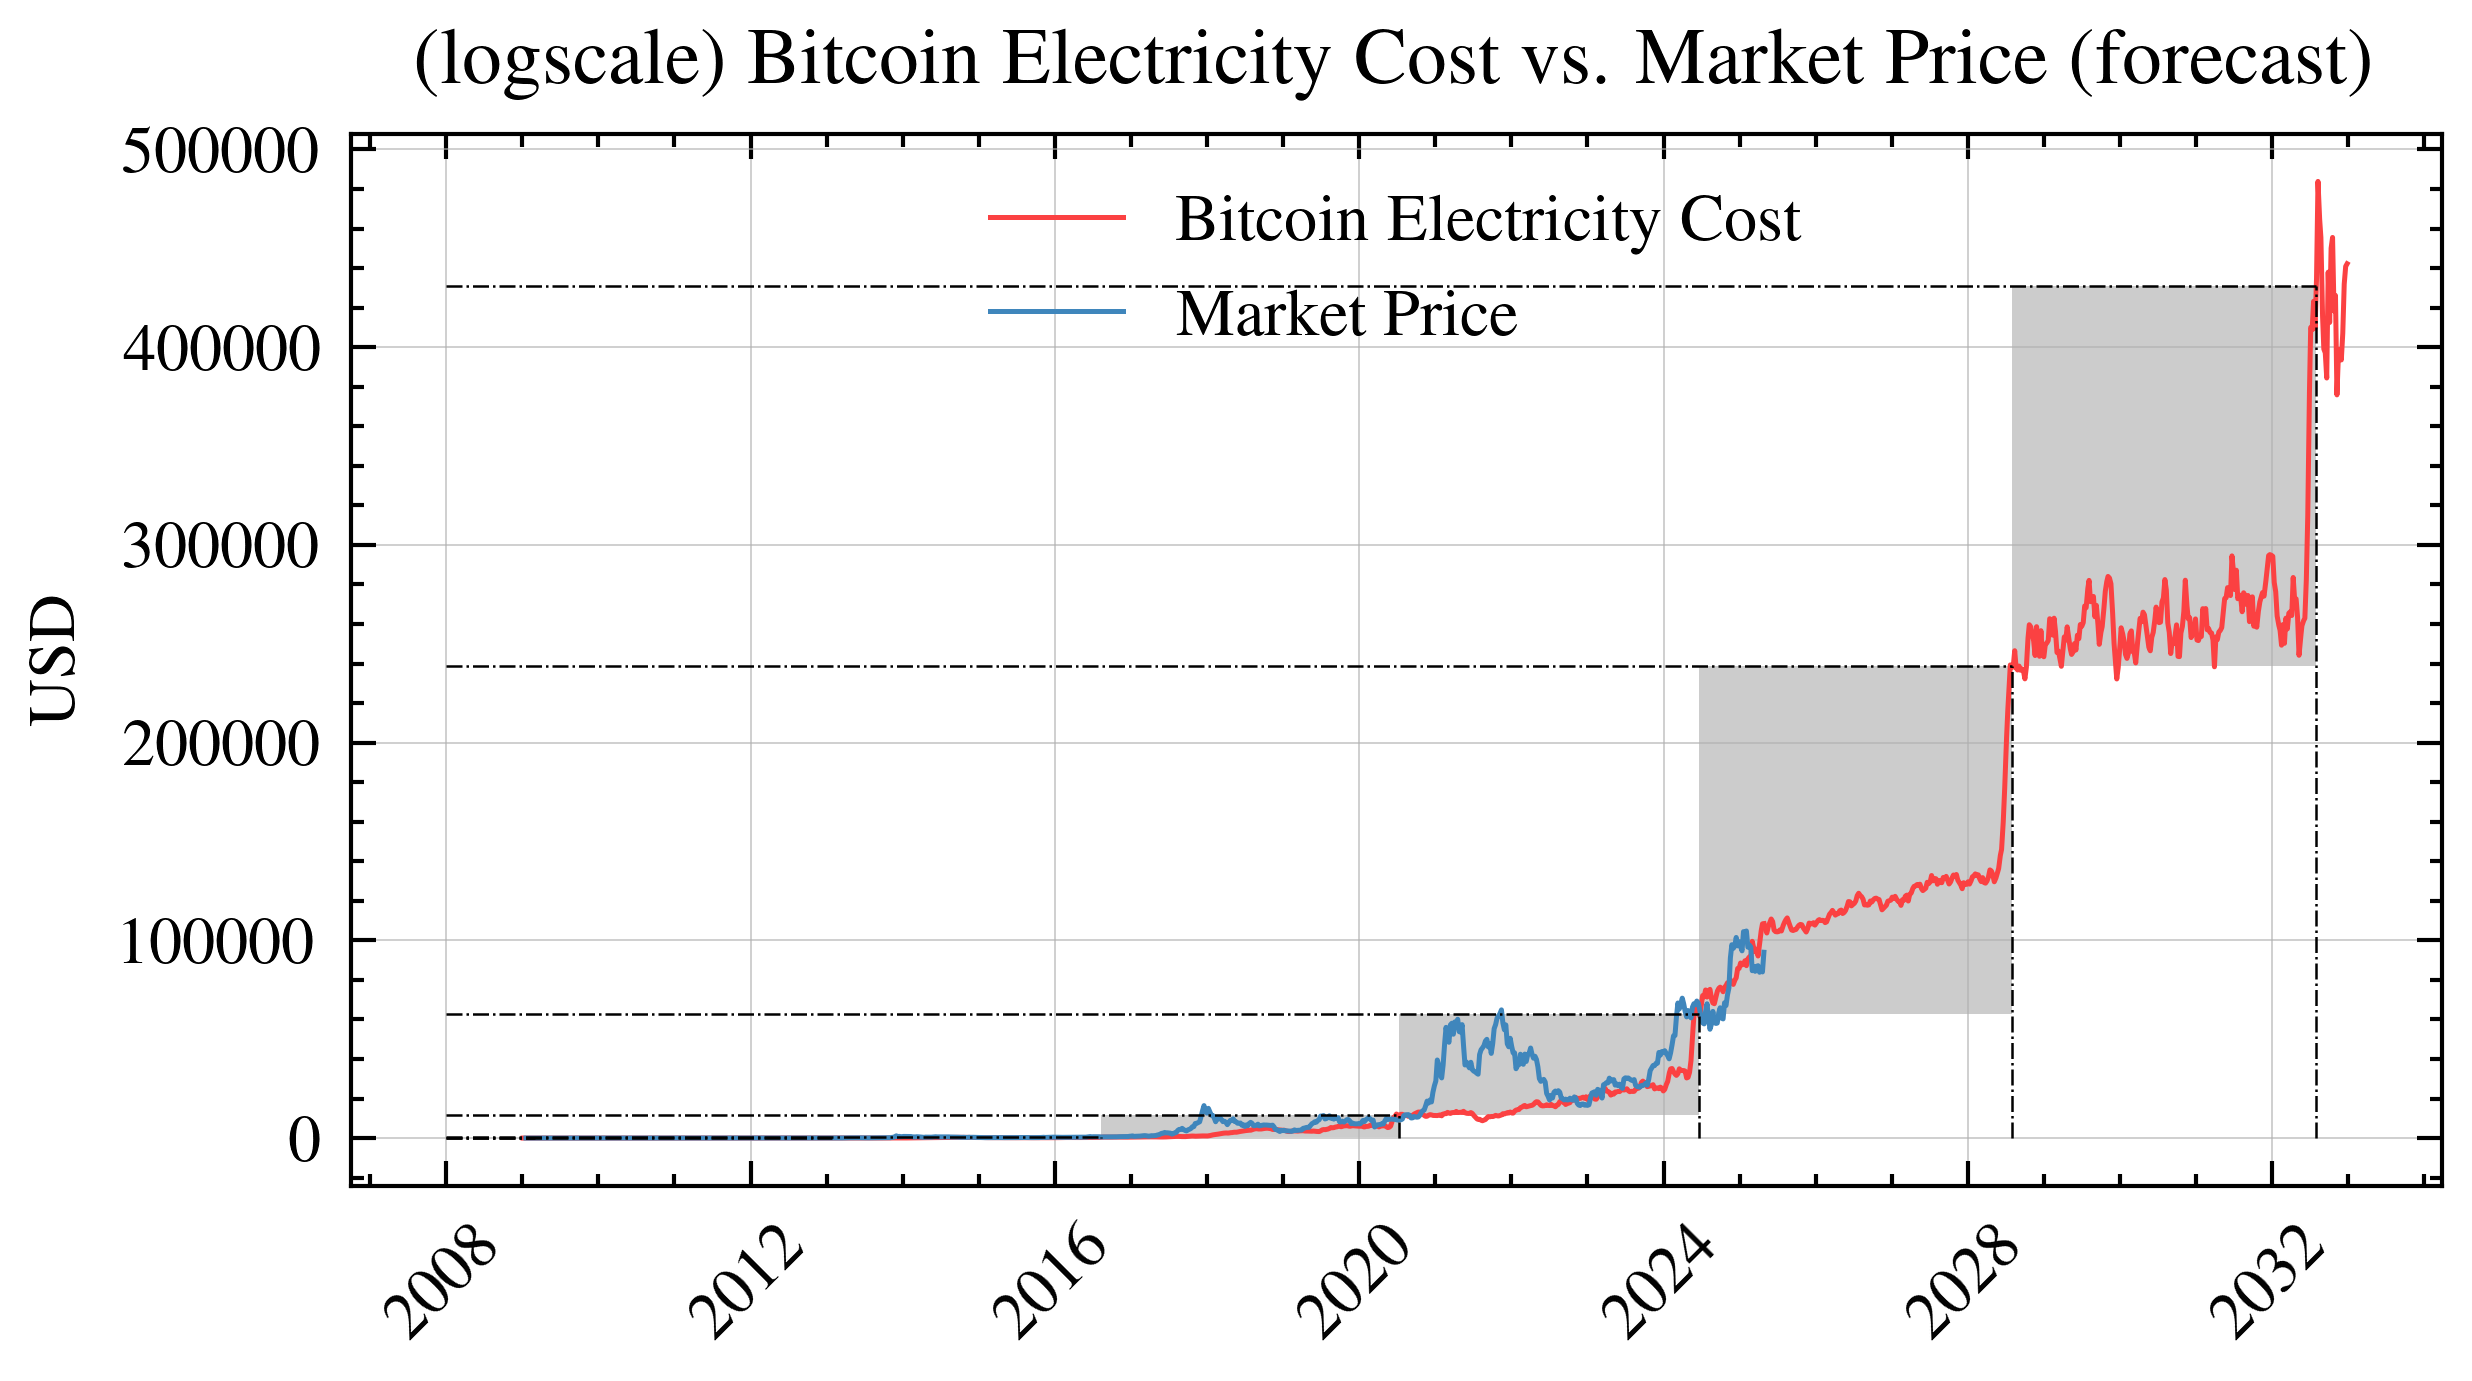

In [65]:
start_date = '2008-01-01'
end_date = '2033-01-01'
df_nfiltered = main_df[start_date:end_date].copy()
df_filtered = main_df[start_date:end_date].copy().resample('D').interpolate('linear').fillna(0.00001)
halvings = simulated_bitcoins_lores[start_date:end_date].index
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_nfiltered.index, df_nfiltered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.6)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    for halving in halvings:
        tm =  halving+ datetime.timedelta(days=60)
        vl =  df_filtered.loc[tm]['mining_cost']
        plt.plot([pd.to_datetime(start_date),tm], [vl,vl], color='black',  linestyle='-.', linewidth=0.3)
        plt.vlines(tm,0,vl, colors='black', linestyles='-.', linewidth=0.3)

    if len(halvings)>1 :
        for i in range(len(halvings)-1):
            tm1 =  halvings[i]+ datetime.timedelta(days=60)
            tm2 =  halvings[i+1]+ datetime.timedelta(days=60)
            vl1 =  df_filtered.loc[tm1]['mining_cost']
            vl2 =  df_filtered.loc[tm2]['mining_cost']
            plt.fill([tm1,tm1,tm2,tm2], [vl1,vl2,vl2,vl1], color='black', alpha=0.2,linestyle='', linewidth=0.6)

    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecaststf4.png')
    plt.show()

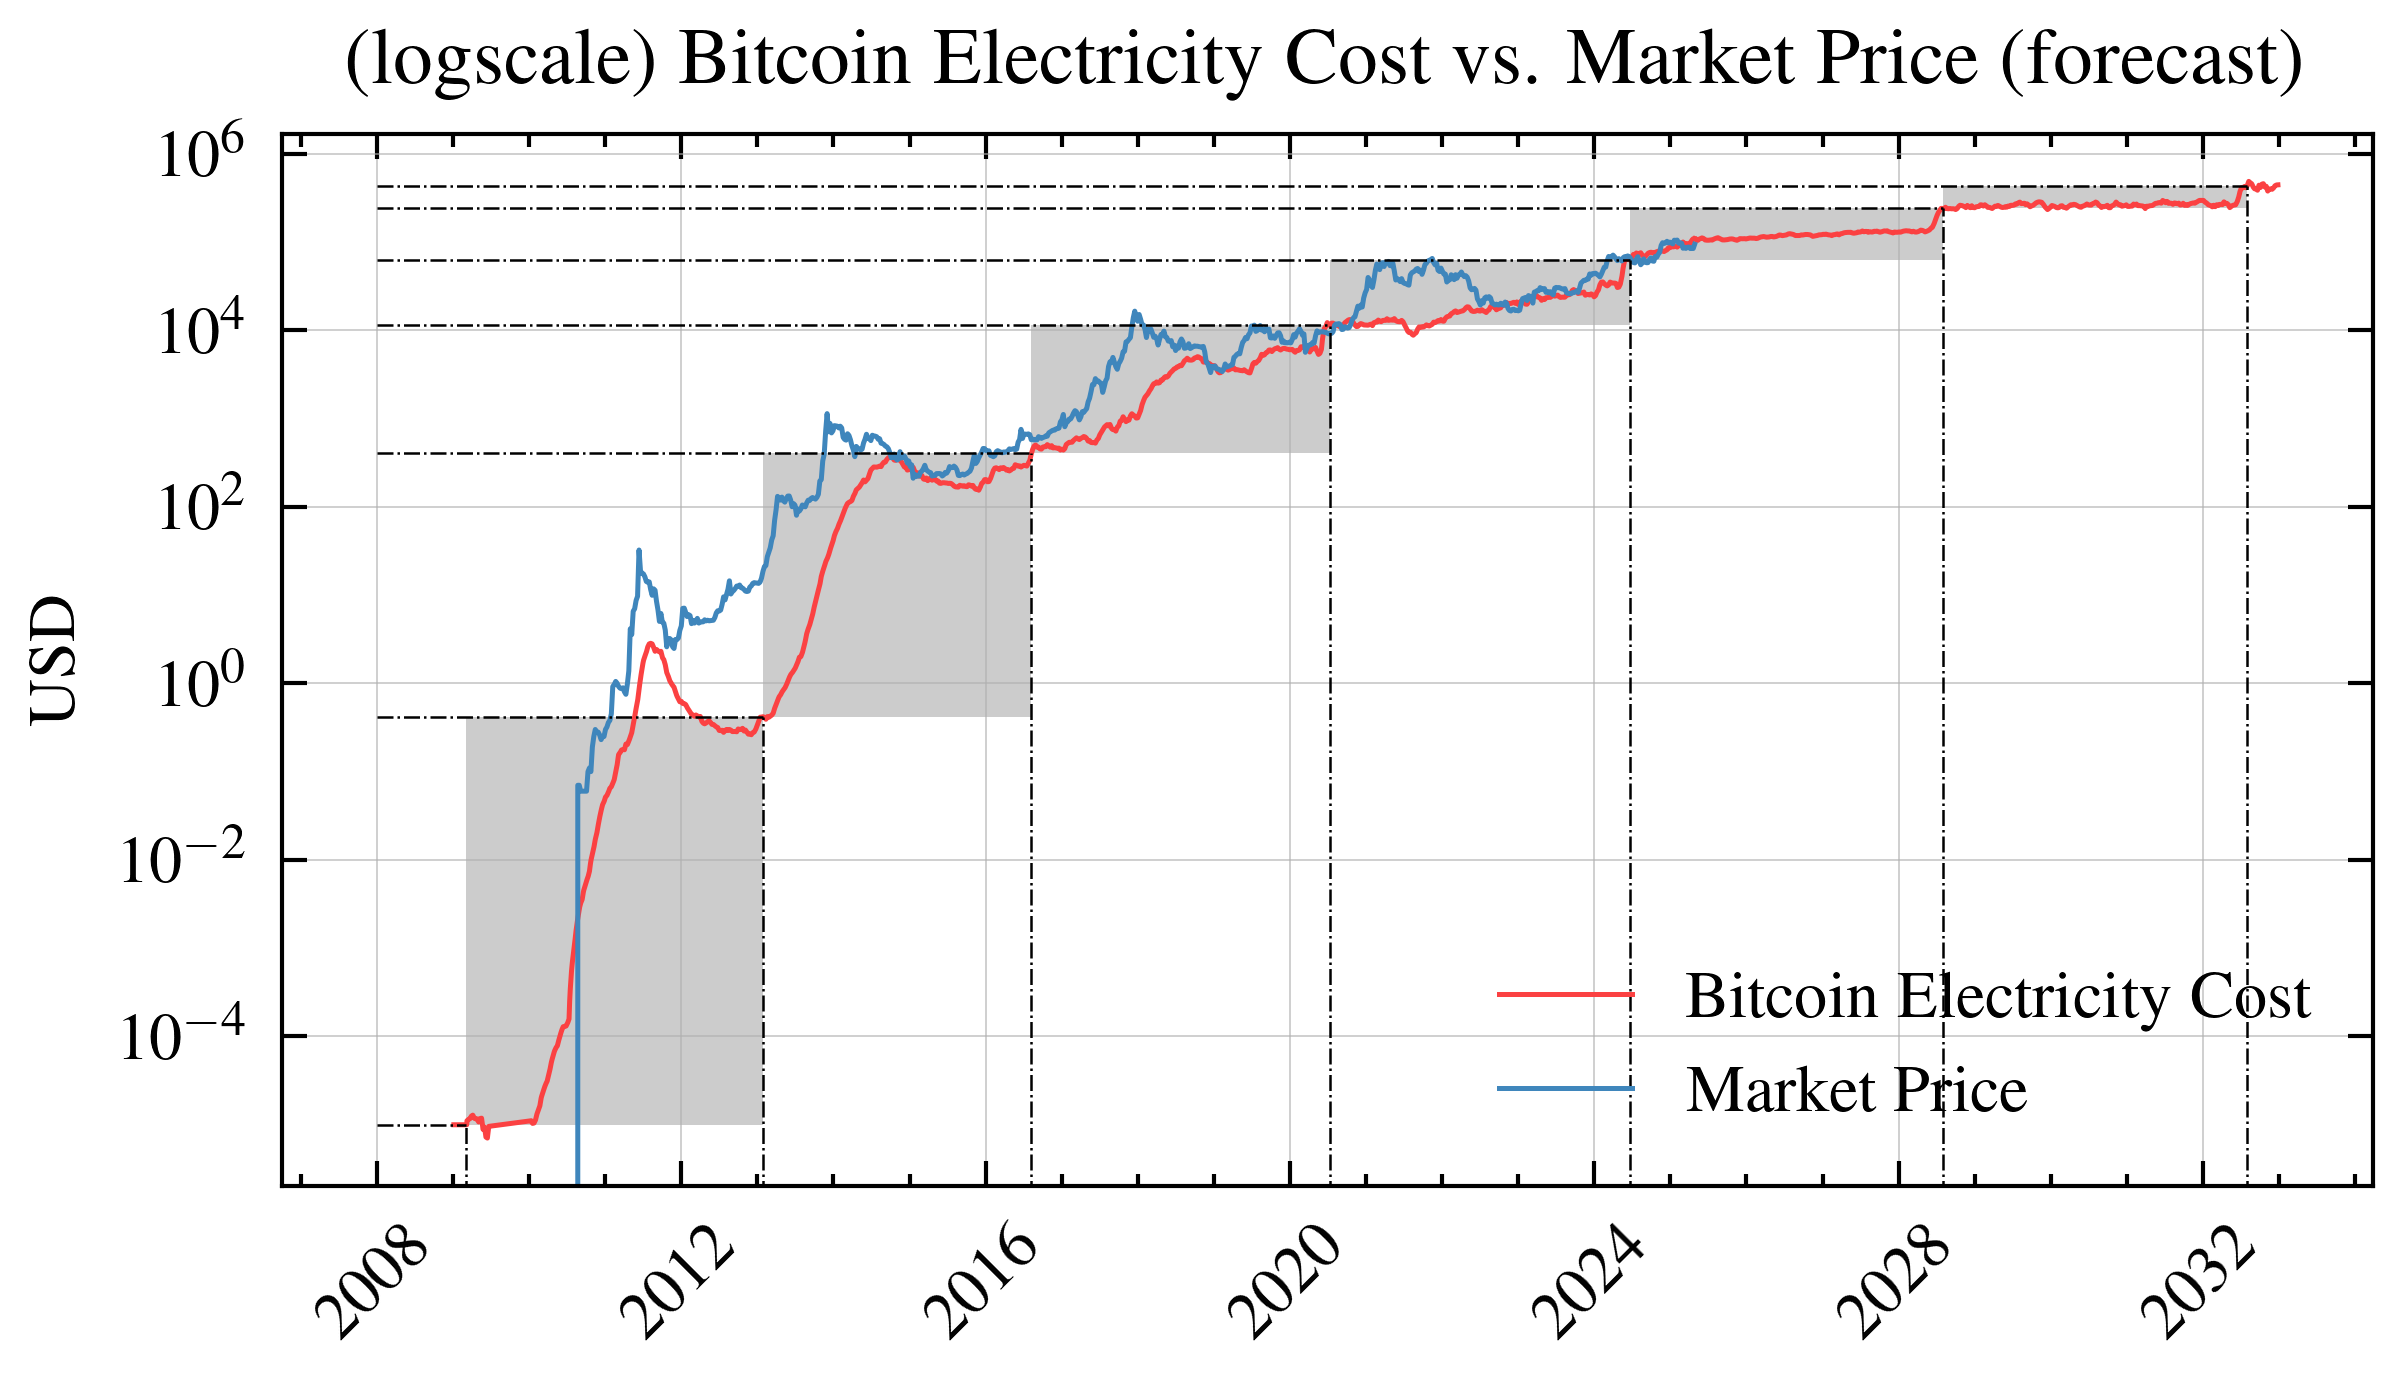

In [66]:
start_date = '2008-01-01'
end_date = '2033-01-01'
df_nfiltered = main_df[start_date:end_date].copy()
df_filtered = main_df[start_date:end_date].copy().resample('D').interpolate('linear').fillna(0.00001)
halvings = simulated_bitcoins_lores[start_date:end_date].index
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], color=LINE_COLOR_RED, linestyle='-', linewidth=0.6)
    plt.plot(df_nfiltered.index, df_nfiltered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.6)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    for halving in halvings:
        tm =  halving+ datetime.timedelta(days=60)
        vl =  df_filtered.loc[tm]['mining_cost']
        plt.plot([pd.to_datetime(start_date),tm], [vl,vl], color='black',  linestyle='-.', linewidth=0.3)
        plt.vlines(tm,0,vl, colors='black', linestyles='-.', linewidth=0.3)

    if len(halvings)>1 :
        for i in range(len(halvings)-1):
            tm1 =  halvings[i]+ datetime.timedelta(days=60)
            tm2 =  halvings[i+1]+ datetime.timedelta(days=60)
            vl1 =  df_filtered.loc[tm1]['mining_cost']
            vl2 =  df_filtered.loc[tm2]['mining_cost']
            plt.fill([tm1,tm1,tm2,tm2], [vl1,vl2,vl2,vl1], color='black', alpha=0.2,linestyle='', linewidth=0.6)

    plt.ylabel('USD')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecaststf5.png')
    plt.show()